In [1]:
#from statsmodels.tsa.statespace.sarimax import SARIMAX
#from statsmodels.tsa.stattools import adfuller
#import statsmodels.api as sm
#import statsmodels.graphics.tsaplots as smt
import seaborn as sns
from tempfile import TemporaryFile
import matplotlib.patches as mpatches
#from statsmodels.graphics.tsaplots import plot_pacf , plot_acf
#from statsmodels.tsa.ar_model import AR
#from statsmodels.tsa.holtwinters import ExponentialSmoothing
#import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
#import statsmodels.api as sm
import datetime
import numpy as np
import os
from sklearn.metrics import mean_squared_error
import h5py
#from random import random
#from sklearn.metrics import mean_squared_error
#import scipy.stats as stats


from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import Flatten
from keras.layers import LSTM
import pandas as pd
#from PyAstronomy import pyasl
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import model_from_json
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.initializers import RandomUniform

sns.set()

Using TensorFlow backend.


In [2]:
#file locations, features and target
path = "C:\\Users\\mooc\\Documents\\Bosch-MT\\Daten\\UCI_machine_learning_repository\\Condition_hydraulic_systems_data_set"
feature_list = ['PS1', 'PS2', 'PS3', 'PS4', 'PS5', 'PS6', 'EPS1', 'FS1', 'FS2', 'TS1', 'TS2', 'TS3', 'TS4', 'VS1', 'CE', 'CP', 'SE']
feature_dict = {}
target_list = ['cooler cond.', 'valve cond.', 'pump leakage', 'hydraulic accum.', 'stable flag' ]
target_dict = {}
target = "profile.txt"

In [3]:
#read in target values from target file

target_dict = {key: [] for key in target_list}
target_file = os.path.join(path, target)

with open(target_file) as f:
    for line in f:
        value = line.split()
        for i in range(0, len(value)):
            #value_list =[]
            #for j in range(0,6000):
            #    value_list.append(int(value[i]))
            
            #print(len(value_list))
            target_dict[target_list[i]].append(int(value[i]))
      

In [4]:
for f in feature_list:
    file_name = os.path.join(path, "%s.txt" %(f)) 
    with open(file_name) as file:
        print(f)
        feature_dict[f]= [[float(digit) for digit in line.split()] for line in file]

PS1
PS2
PS3
PS4
PS5
PS6
EPS1
FS1
FS2
TS1
TS2
TS3
TS4
VS1
CE
CP
SE


PS1 = 	Pressure bar 100 Hz

PS2 = 	Pressure bar 100 Hz

PS3 =   Pressure bar 100 Hz

PS4 = 	Pressure bar 100 Hz

PS5 =   Pressure bar 100 Hz

PS6 =   Pressure bar 100 Hz

EPS1 =  Motor Power W 100 Hz

FS1 = Volume flow l/min 10 Hz

FS2 = Volume flow l/min 10 Hz

TS1 = Temperature °C 1 Hz

TS2 = Temperature °C  1 HZ

TS3 = Temperature °C 1 Hz

TS4 = Temperature °C 1 Hz

VS1 = Vibration mm/s 1 Hz

CE = Cooling efficiency (virtual) % 1 Hz

CP = Cooling power (Virtual) kW 1Hz

SE = Efficiency factor % 1 Hz

In [5]:
#function to plot features
def plot_features(feature_dict, feature_list, ceiling=10):
    
    print(feature_list)
    
    for i in range(0,len(feature_dict[feature_list])):
        print("%s of %s" %(i, len(feature_dict[feature_list])))
        plt.subplots(figsize=(20,10))
        plt.plot(feature_dict[feature_list][i])   
        plt.show()
        if i == ceiling-1:
            break

In [6]:
def one_plot_features(feature_dict, feature, ceiling=10):

    plt.figure(figsize=(20,10))

    for i in range(0,6000):
    #plt.figure(figsize=(20,10))
        plt.plot(feature_dict[feature][i])
        if i == ceiling - 1:
            break
        
    plt.show()


In [ ]:
#variable overview multiple plots 
#for i in range(0, len(feature_list)):
#    plot_features(feature_dict, feature_list[i], ceiling=1)

In [7]:
#create target tensor
#print(len(target_dict[target_list[0]]))

if True:
    n_trows = len(target_dict[target_list[0]])
    n_tcolumns = len(feature_dict[feature_list[0]][0])
    n_targets = len(target_list)
    print("Dimensions: %s, %s, %s" %(n_trows, n_tcolumns, n_targets))

    target_2d = np.zeros((2205,6000))
    target_value_list = list(target_dict.values())


    for target in range(0, n_targets):
        for row in range(0, n_trows):
                     for column in range(0,n_tcolumns):
                         target_2d[row][column]=target_value_list[target][row]

        if target == 0:
            target_tensor= np.copy(target_2d)
        else:
            target_tensor = np.dstack((target_tensor,target_2d))
                    

#print(target_tensor.shape)

#print(target_tensor[0,0,4])
#print(target_tensor)

Dimensions: 2205, 6000, 5


In [8]:
#np.pad(feature_dict[feature_list[3]][4], (0,0), 'constant')
feature_dict[feature_list[0]][0][0]

151.47

In [9]:
#create feature tensor
if True:
    
    n_frows = len(feature_dict[feature_list[0]])
    n_fcolumns = len(feature_dict[feature_list[0]][0])
    n_features = len(feature_list)

    feature_2d = np.zeros((n_frows,n_fcolumns))
    #feature_tensor = np.zeros((n_frows, n_fcolumns, n_features))
    
    
    
    for feature in range(0, n_features):
        for row in range(0, n_frows):
            for column in range(0,n_tcolumns):
                if len(feature_dict[feature_list[feature]][row]) == n_fcolumns:
                    #print(feature_dict[feature_list[feature]][row][column])
                    feature_2d[row][column]=feature_dict[feature_list[feature]][row][column]
                else:
                    padding =  n_fcolumns - len(feature_dict[feature_list[feature]][row])
                    feature_dict[feature_list[feature]][row] = np.pad(feature_dict[feature_list[feature]][row], (0, padding), 'constant')
                    feature_2d[row][column]=feature_dict[feature_list[feature]][row][column]

        if feature == 0:
            feature_tensor = np.copy(feature_2d)
            #print(feature_tensor)
        else:
            feature_tensor = np.dstack((feature_tensor,feature_2d))
            #print(feature_tensor)
                    

#print(feature_tensor.shape)

#print(feature_tensor[:,:,0])
#print(feature_tensor[0,1,0])

In [10]:
print(feature_tensor.shape)
#feature_tensor[:,:,0]

(2205, 6000, 17)


In [11]:
#normalize features for LSTM

def scale_feature_tensor(feature_tensor):
    
   
    rows, columns, features = feature_tensor.shape
    #scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = StandardScaler()
    #scaler = scaler.fit(feature_tensor)

    for feature in range(0,features):
        #print("Shape before: %s" %(feature) + str(feature_tensor[:,:,feature].shape))
        #scaler = scaler.fit(feature_tensor[:,:,feature])
        scaled_feature_tensor = scaler.fit_transform(feature_tensor[:,:,feature])
        #print("Shape after: %s" %(feature) + str(scaled_feature_tensor[:,:].shape))
        #print(scaled_feature_tensor.shape)
        #print(scaled_feature_tensor[:,:])
        
        if feature == 0:
            full_scaled_feature_tensor = np.copy(scaled_feature_tensor)
            #print(feature_tensor)
        else:
            full_scaled_feature_tensor = np.dstack((full_scaled_feature_tensor, scaled_feature_tensor,))
        
    return full_scaled_feature_tensor, scaler


In [12]:
#scale feature tensor
print(feature_tensor[:,:,0].shape)
scaled_feature_tensor, scaler = scale_feature_tensor(feature_tensor)

(2205, 6000)


In [13]:
#all tensors
print(feature_tensor.shape)
print(feature_tensor[0:2,:,1])

print(scaled_feature_tensor.shape)
print(scaled_feature_tensor[0:2,:,4])

print(target_tensor.shape)
print(target_tensor[0:2,:,1])

(2205, 6000, 17)
[[125.5  125.39 125.4  ... 125.11 125.14 125.1 ]
 [125.06 125.08 125.09 ... 125.13 125.09 125.04]]
(2205, 6000, 17)
[[1.33279818 1.35091598 1.37963768 ... 1.00119322 0.99287627 0.96186644]
 [0.92351544 0.90022256 0.89097597 ... 0.789625   0.79859663 0.79013632]]
(2205, 6000, 5)
[[130. 130. 130. ... 130. 130. 130.]
 [130. 130. 130. ... 130. 130. 130.]]


In [14]:
#Combine (scaled) feature and target Tensor
combined_tensor = np.dstack((feature_tensor, target_tensor))
scaled_combined_tensor = np.dstack((scaled_feature_tensor, target_tensor))
print(combined_tensor.shape)
print(scaled_combined_tensor.shape)


(2205, 6000, 22)
(2205, 6000, 22)


In [28]:
#persist array feature tensor (2205, 6000, 22)

h5f.close()
h5f = h5py.File('combined_feature_tensor_2205x6000x22.h5', 'w')
h5f.create_dataset('combined_feature_tensor_2205x6000x22', data=combined_tensor)
h5f.create_dataset('scaled_combined_feature_tensor_2205x6000x22', data=scaled_combined_tensor)
h5f.close()

In [29]:
#test load saved tensor
h5f_read = h5py.File('combined_feature_tensor_2205x6000x22.h5','r')
test_tensor = h5f_read['combined_feature_tensor_2205x6000x22'][:]
print(h5f_read.get('combined_feature_tensor_2205x6000x22'))
print(test_tensor.shape)
h5f_read.close()

<HDF5 dataset "combined_feature_tensor_2205x6000x22": shape (2205, 6000, 22), type "<f8">
(2205, 6000, 22)


In [34]:
#print(combined_tensor[0,47,0])
#print(test_tensor[0,47,0])

In [15]:
#get index of targets
def get_index_of_target(target):
    
    target_index = {k:i for i,k in enumerate(target_dict.keys())}
    print("Index values: " + str(target_index))
    
    index = len(feature_tensor[0,0,:]) + target_index[target]
    
    return index 

In [16]:

ix_leakage = get_index_of_target('pump leakage')
ix_stable = get_index_of_target('stable flag')
ix_hyd = get_index_of_target('hydraulic accum.')
ix_cooler = get_index_of_target('cooler cond.')
ix_valve = get_index_of_target('valve cond.')
#print(ix_leakage, ix_stable, ix_hyd)
#(combined_tensor[:,1,ix_stable]==0)


stable_list = [0,1]
valve_list = [73,80,90,100]
leakage_list = [0,1,2]
hydraulic_list = [90,100,115,130]
cooler_list= [3,20,100]


if True:
    tensor_dict = {}
    scaled_tensor_dict = {}
    
    counter = 1
    for stable in stable_list:
        #print(stable)
        for valve in valve_list:
            for leakage in leakage_list:
                for hyd in hydraulic_list:
                    for cooler in cooler_list:
                        
                        
                        tensor = combined_tensor[(combined_tensor[:,1,ix_leakage]==leakage)&
                                    (combined_tensor[:,1,ix_stable]==stable)&
                                    (combined_tensor[:,1,ix_hyd]==hyd)& 
                                    (combined_tensor[:,1,ix_cooler]==cooler)& 
                                    (combined_tensor[:,1,ix_valve]==valve)]

    
                        if len(tensor) != 0:
                            print("groeser null")
                            tensor_dict['c%s_h%s_pl%s_v%s_s%s' %(cooler,hyd,leakage,valve,stable)] = tensor


                        
                            #scaled_tensor_dict['c%s_h%s_pl%s_v%s_s%s' %(cooler,hyd,leakage,valve,stable)] = scaled_combined_tensor[(scaled_combined_tensor[:,1,ix_leakage]==leakage)&
                            #                                                                                            (combined_tensor[:,1,ix_stable]==stable) & 
                            #                                                                                            (combined_tensor[:,1,ix_hyd]==hyd)&
                            #                                                                                            (combined_tensor[:,1,ix_cooler]==cooler)&
                            #                                                                                            (combined_tensor[:,1,ix_valve]==valve)]
                            print("tensor_%s_%s_%s_%s_%s" % (cooler, hyd, leakage, valve, stable))
                            print(tensor_dict['c%s_h%s_pl%s_v%s_s%s' %(cooler,hyd,leakage,valve,stable)].shape)
                            print(" Set: " + str(counter))
                            counter +=1
                    

print(len(tensor_dict.keys()))           
#print(tensor_dict["c100_h130_pl0_v100_s0"][:,:,0:17])
#print(scaled_tensor_dict["c100_h130_pl0_v100_s0"].shape)

Index values: {'stable flag': 0, 'valve cond.': 2, 'hydraulic accum.': 1, 'cooler cond.': 3, 'pump leakage': 4}
Index values: {'stable flag': 0, 'valve cond.': 2, 'hydraulic accum.': 1, 'cooler cond.': 3, 'pump leakage': 4}
Index values: {'stable flag': 0, 'valve cond.': 2, 'hydraulic accum.': 1, 'cooler cond.': 3, 'pump leakage': 4}
Index values: {'stable flag': 0, 'valve cond.': 2, 'hydraulic accum.': 1, 'cooler cond.': 3, 'pump leakage': 4}
Index values: {'stable flag': 0, 'valve cond.': 2, 'hydraulic accum.': 1, 'cooler cond.': 3, 'pump leakage': 4}
groeser null
tensor_3_90_0_73_0
(10, 6000, 22)
 Set: 1
groeser null
tensor_20_90_0_73_0
(10, 6000, 22)
 Set: 2
groeser null
tensor_100_90_0_73_0
(10, 6000, 22)
 Set: 3
groeser null
tensor_3_100_0_73_0
(10, 6000, 22)
 Set: 4
groeser null
tensor_20_100_0_73_0
(10, 6000, 22)
 Set: 5
groeser null
tensor_100_100_0_73_0
(10, 6000, 22)
 Set: 6
groeser null
tensor_3_115_0_73_0
(10, 6000, 22)
 Set: 7
groeser null
tensor_20_115_0_73_0
(10, 6000, 

MemoryError: 

In [17]:
# extract tensor for pump leakage analysis
#leakage0_tensor = tensor_dict["c100_h130_pl0_v100_s0"]
#leakage1_tensor = tensor_dict["c100_h130_pl1_v100_s0"]
#leakage2_tensor = tensor_dict["c100_h130_pl2_v100_s0"]
#print(leakage0_tensor.shape)

In [101]:
'''h5f.close()
h5f = h5py.File('all_leakage_tensors.h5', 'w')
h5f.create_dataset('leakage0_tensor', data=leakage0_tensor)
h5f.create_dataset('leakage1_tensor', data=leakage1_tensor)
h5f.create_dataset('leakage2_tensor', data=leakage2_tensor)
h5f.close()
'''

(10, 6000, 22)


### Plot Features and failure Tensor

In [18]:
def plot_cycles(tensor_dict, firstkey, secondkey=None, begin=0, end=6000, feature=0):
    
    if secondkey == None:
        
        plt.figure(figsize=(20,10))
        plt.plot(tensor_dict[firstkey][begin:end,feature])
        #plt.plot(second_tensor[begin:end,feature])
        plt.show()
    
    else:
        plt.figure(figsize=(20,10))
        plt.plot(tensor_dict[firstkey][begin:end,feature])
        plt.plot(tensor_dict[secondkey][begin:end,feature])
        #plt.plot(second_tensor[begin:end,feature])
        plt.show()
    

#print(full_stacked_tensor_dict[best])
#print(scaled_full_stacked_tensor_dict[best][0:60000, 0])
#plot_cycles(scaled_full_stacked_tensor_dict, best , secondkey=None, begin=0, end=6000, feature=0)

In [19]:
#stacked columns t rows
if True:
    def stack_columns_to_rows(tensor):
        
        rows, columns, features  = tensor.shape
        
        #print(rows, columns, features)
        for feature in range(0,features):
                        
            
            for row in range(0, rows):
        
                if row == 0:
                    stacked_tensor = np.copy(tensor[row,:,feature])
                
                else:
                    stacked_tensor = np.hstack((stacked_tensor,tensor[row,:,feature]))
            
            
                
                
            if feature == 0:
                full_stacked_tensor = np.copy(stacked_tensor.reshape(len(stacked_tensor),1))
            
            else:
                full_stacked_tensor = np.hstack((full_stacked_tensor, stacked_tensor.reshape(len(stacked_tensor),1)))
        
        return full_stacked_tensor


In [20]:
if True:
    
    full_stacked_tensor_dict = {}  
    i = 1
    
    for key in tensor_dict.keys():
        full_stacked_tensor_dict[key] = stack_columns_to_rows(tensor_dict[key][:,:,0:17])
        #print(i)
        i +=1
     

    
if False:
    
    scaled_full_stacked_tensor_dict = {} 
    j=1
    
    for key in tensor_dict.keys():
        scaled_full_stacked_tensor_dict[key] = stack_columns_to_rows(scaled_tensor_dict[key][:,:,0:17])
        #print(j)
        j +=1
     
    print(scaled_full_stacked_tensor_dict["c100_h130_pl0_v100_s0"])  



def plot_cycles_all_features(tensor_dict, firstkey, secondkey=None ):
    
    if secondkey == None: 
        if firstkey in tensor_dict:
            #print(tensor_dict[firstkey].shape[1])
    
            for feat in range(0,tensor_dict[firstkey].shape[1]):
                print(feat)
                plot_cycles(tensor_dict, firstkey, begin=0, end=60000, feature=feat)
         
        else:
            print("combination/tensor doesn't exist")

                
    if secondkey != None:
        if firstkey in tensor_dict:
            #print(tensor_dict[key].shape[1])
    
            for feat in range(0,tensor_dict[firstkey].shape[1]):
                print(feat)
                plot_cycles(tensor_dict, firstkey, secondkey=secondkey, begin=0, end=60000, feature=feat)
        
        else:
            print("combination/tensor doesn't exist")
        


best="c100_h130_pl0_v100_s0"
#worse = "c100_h130_pl1_v100_s0"
#worst="c3_h90_pl2_v73_s0"
print(full_stacked_tensor_dict[best].shape)


#plot_cycles_all_features(full_stacked_tensor_dict, worst)
#plot_cycles_all_features(full_stacked_tensor_dict, best, secondkey=worse)
#plot_cycles_all_features(scaled_full_stacked_tensor_dict, best, secondkey=None)

(60000, 17)


In [21]:
target_state_dict={}

target_state_dict['stable flag']=[0,1 ]
target_state_dict['pump leakage']=[0,1,2]
target_state_dict['cooler cond.']=[3,20,100]
target_state_dict['valve cond.']=[73,80,90,100]
target_state_dict['hydraulic accum.']=[90,100,115,130]

#target_state_dict

#test = target_state_dict.get("valve cond.")



### Prepare Tensors for Training with window size etc

In [22]:
# split a multivariate sequence one step into samples
def data_preparation_one_step(sequences, look_back, look_ahead):
    X = list()
    print("look_back: " + str(look_back))
    print("look_ahead: " + str(look_ahead))
    print("Sequence Shape: " + str(sequences.shape)) 
    
    
    for i in range(len(sequences)):
        #print(i)
        #rint(len(sequepnces))
        # find the end of this pattern
        end_ix = i + look_back
        # check if we are beyond the dataset
        if end_ix+1 > len(sequences) :
            break
        elif end_ix+look_ahead > len(sequences):
            break
        #gather input and output parts of the pattern
        #print(sequences[i:end_ix])
        #print(sequences[end_ix:end_ix+look_ahead])
                
        seq_x = sequences[i:end_ix]
        #seq_y = sequences[end_ix:end_ix+look_ahead]
        #print("x sequence length: " + str(len(seq_x)))
        #print("y sequence length: " + str(len(seq_y)))
        
   
        #seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        #y.append(seq_y)
    return array(X) #array(y)

In [23]:
def transform_data_for_LSTM(train_tensor, look_back, look_ahead):
    
    full_stacked_train_tensor = stack_columns_to_rows(train_tensor)
    
    X  = data_preparation_one_step(full_stacked_train_tensor, look_back, look_ahead)
    
    print(X.shape)
    
    
    return X

In [26]:
#
X_full_staked_tensor = {}
y_full_staked_tensor = {}

X_scaled_full_staked_tensor = {}
y_scaled_full_staked_tensor = {}

look_ahead=5
look_back=40

leakage_key_list=['c100_h130_pl0_v100_s0', 'c100_h130_pl1_v100_s0', 'c100_h130_pl2_v100_s0']
valve_key_list=['c100_h130_pl0_v100_s0', 'c100_h130_pl0_v90_s0', 'c100_h130_pl0_v80_s0', 'c100_h130_pl0_v73_s0' ]
hydraulic_key_list=['c100_h130_pl0_v100_s0', 'c100_h115_pl0_v100_s0', 'c100_h100_pl0_v100_s0', 'c100_h90_pl0_v100_s0']
stable_key_list=['c100_h130_pl0_v100_s0', 'c100_h130_pl0_v100_s1']
cooler_key_list=['c100_h130_pl0_v100_s0', 'c20_h130_pl0_v100_s0', 'c3_h130_pl0_v100_s0']

all_key_list=['c100_h130_pl0_v100_s0', 'c100_h130_pl1_v100_s0', 'c100_h130_pl2_v100_s0', 'c100_h130_pl0_v90_s0', 
              'c100_h130_pl0_v80_s0', 'c100_h130_pl0_v73_s0',
              'c100_h115_pl0_v100_s0', 'c100_h100_pl0_v100_s0', 'c100_h90_pl0_v100_s0', 
              'c100_h130_pl0_v100_s1',
              'c20_h130_pl0_v100_s0', 'c3_h130_pl0_v100_s0'
             ]
#print(tensor_dict[train_key].shape)
print(tensor_dict['c100_h130_pl0_v100_s0'][:,:,0:17].shape)
key_list = ['c100_h130_pl0_v100_s0']

tensor_dict.keys()

#for key in tensor_dict.keys():
for key in all_key_list:
    #print(key)
   #X_full_staked_tensor[key], y_full_staked_tensor[key] = transform_data_for_LSTM(tensor_dict[key][:,:,0:17], look_back, look_ahead)
    X_full_staked_tensor[key] = transform_data_for_LSTM(tensor_dict[key][:,:,0:17], look_back, look_ahead)
    #X_scaled_full_staked_tensor[key], y_scaled_full_staked_tensor[key] = transform_data_for_LSTM(scaled_tensor_dict[key][:,:,0:17], n_steps=n_steps)


(10, 6000, 17)
look_back: 40
look_ahead: 5
Sequence Shape: (60000, 17)
(59956, 40, 17)
look_back: 40
look_ahead: 5
Sequence Shape: (60000, 17)
(59956, 40, 17)
look_back: 40
look_ahead: 5
Sequence Shape: (60000, 17)
(59956, 40, 17)
look_back: 40
look_ahead: 5
Sequence Shape: (60000, 17)
(59956, 40, 17)
look_back: 40
look_ahead: 5
Sequence Shape: (60000, 17)
(59956, 40, 17)
look_back: 40
look_ahead: 5
Sequence Shape: (60000, 17)
(59956, 40, 17)
look_back: 40
look_ahead: 5
Sequence Shape: (60000, 17)
(59956, 40, 17)
look_back: 40
look_ahead: 5
Sequence Shape: (60000, 17)
(59956, 40, 17)
look_back: 40
look_ahead: 5
Sequence Shape: (114000, 17)
(113956, 40, 17)
look_back: 40
look_ahead: 5
Sequence Shape: (66000, 17)
(65956, 40, 17)
look_back: 40
look_ahead: 5
Sequence Shape: (60000, 17)
(59956, 40, 17)
look_back: 40
look_ahead: 5
Sequence Shape: (60000, 17)
(59956, 40, 17)


In [59]:
#X_full_staked_tensor.keys()

In [27]:
y_full_staked_tensor['c100_h130_pl0_v100_s0'][1,:,1]

KeyError: 'c100_h130_pl0_v100_s0'

In [28]:
print(tensor_dict['c100_h130_pl0_v100_s0'][:,:,0:17].shape)
#tensor_dict['c100_h130_pl0_v100_s0'][:,:,0:17]
#tensor_dict['c100_h130_pl0_v100_s0'][1:5].shape
#sequences[i:end_ix], sequences[end_ix: end_ix+look_ahead]

test_full_stacked_train_tensor = stack_columns_to_rows(tensor_dict['c100_h130_pl0_v100_s0'][:,:,0:17])
print(test_full_stacked_train_tensor.shape)
print(test_full_stacked_train_tensor[0:15,1])
print(test_full_stacked_train_tensor[10:15,1])

(10, 6000, 17)
(60000, 17)
[125.63  125.59  125.56  125.31  124.88  124.61  112.19   71.461  37.664
  29.969  25.766  22.203  19.102  16.453  14.148]
[25.766 22.203 19.102 16.453 14.148]


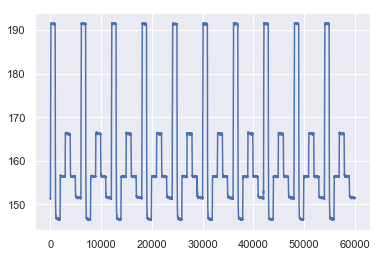

In [29]:
plt.plot(test_full_stacked_train_tensor[:,0])
plt.show()

In [189]:
X_full_staked_tensor['c100_h130_pl0_v100_s0'].shape

(59956, 40, 17)

In [188]:
y_full_staked_tensor['c100_h130_pl0_v100_s0'].shape

(59956, 5, 17)

In [107]:
# split a multivariate sequence one step into samples
'''def data_preparation_one_step(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        #rint(len(sequepnces))
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix+1 > len(sequences):
            break
        #gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix], sequences[end_ix]
        #seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
'''

In [108]:
'''def transform_data_for_LSTM(train_tensor, n_steps=5):
    
    full_stacked_train_tensor = stack_columns_to_rows(train_tensor)
    
    X, y = data_preparation_one_step(full_stacked_train_tensor, n_steps)
    
    print(X.shape, y.shape)
    
    
    return X, y
'''

In [56]:
#tensor_dict.keys()

In [30]:
#print(X_full_staked_tensor['c100_h130_pl1_v100_s0'].shape)


if True:
    
    X_scaled_full_staked_tensor = {}
    y_scaled_full_staked_tensor = {}
    xscaler = MinMaxScaler()
    yscaler = MinMaxScaler()
    
    for key in X_full_staked_tensor.keys():
        
        print(key)
        #only for 2d tensoren
        #y_scaled_full_staked_tensor[key] = yscaler.fit_transform(y_full_staked_tensor[key])
        
        for feature in range(0,17):
            print(feature)
            X_scaler_tensor = xscaler.fit_transform(X_full_staked_tensor[key][:,:,feature])
            y_scaler_tensor = yscaler.fit_transform(y_full_staked_tensor[key][:,:,feature])
            #y_scaler_tensor = scaler.fit_transform(y_full_staked_tensor[key][:,:])
            if feature == 0:
                X_full_scaled_feature_tensor = np.copy(X_scaler_tensor)
                y_full_scaled_feature_tensor = np.copy(y_scaler_tensor)
            #    print(feature_tensor)
            else:
                X_full_scaled_feature_tensor = np.dstack((X_full_scaled_feature_tensor, X_scaler_tensor))
                y_full_scaled_feature_tensor = np.dstack((y_full_scaled_feature_tensor, y_scaler_tensor))
    
        X_scaled_full_staked_tensor[key]= X_full_scaled_feature_tensor
        y_scaled_full_staked_tensor[key]= y_full_scaled_feature_tensor
    
    
          
    

#print(X_scaled_full_staked_tensor['c100_h130_pl0_v100_s0'].shape)
#y_scaler_tensor = scaler.fit_transform(y_full_staked_tensor[key][:,:])
#print(X_scaled_full_staked_tensor['c100_h130_pl0_v100_s0'])


c100_h115_pl0_v100_s0
0


KeyError: 'c100_h115_pl0_v100_s0'

In [50]:
print(X_scaled_full_staked_tensor.keys())

dict_keys(['c100_h130_pl0_v80_s0', 'c100_h100_pl0_v100_s0', 'c3_h130_pl0_v100_s0', 'c100_h90_pl0_v100_s0', 'c100_h130_pl2_v100_s0', 'c100_h130_pl0_v90_s0', 'c100_h130_pl0_v100_s1', 'c20_h130_pl0_v100_s0', 'c100_h115_pl0_v100_s0', 'c100_h130_pl1_v100_s0', 'c100_h130_pl0_v100_s0', 'c100_h130_pl0_v73_s0'])


In [44]:
print(X_scaled_full_staked_tensor['c100_h130_pl0_v100_s0'].shape)
print(y_scaled_full_staked_tensor['c100_h130_pl0_v100_s0'].shape)

(59956, 40, 17)
(59956, 5, 17)


In [190]:
'''X Y scaled_full_staked_tensor['c100_h130_pl0_v100_s0']
h5f.close()
h5f = h5py.File('all_Y_valve_tensors.h5', 'w')
h5f.create_dataset('Y_scaled_valve100_tensor', data=y_scaled_full_staked_tensor['c100_h130_pl0_v100_s0'])
h5f.create_dataset('Y_scaled_valve90_tensor', data=y_scaled_full_staked_tensor['c100_h130_pl0_v90_s0'])
h5f.create_dataset('Y_scaled_valve80_tensor', data=y_scaled_full_staked_tensor['c100_h130_pl0_v80_s0'])
h5f.create_dataset('Y_scaled_valve73_tensor', data=y_scaled_full_staked_tensor['c100_h130_pl0_v73_s0'])
h5f.close()

h5f.close()
h5f = h5py.File('all_X_valve_tensors.h5', 'w')
h5f.create_dataset('X_scaled_valve100_tensor', data=X_scaled_full_staked_tensor['c100_h130_pl0_v100_s0'])
h5f.create_dataset('X_scaled_valve90_tensor', data=X_scaled_full_staked_tensor['c100_h130_pl0_v90_s0'])
h5f.create_dataset('X_scaled_valve80_tensor', data=X_scaled_full_staked_tensor['c100_h130_pl0_v80_s0'])
h5f.create_dataset('X_scaled_valve73_tensor', data=X_scaled_full_staked_tensor['c100_h130_pl0_v73_s0'])
h5f.close()
'''

In [191]:
''' persist all scaled hydraulic state tensors
h5f.close()
h5f = h5py.File('all_X_hydraulic_tensors.h5', 'w')
h5f.create_dataset('X_scaled_hydraulic130_tensor', data=X_scaled_full_staked_tensor['c100_h130_pl0_v100_s0'])
h5f.create_dataset('X_scaled_hydraulic115_tensor', data=X_scaled_full_staked_tensor['c100_h115_pl0_v100_s0'])
h5f.create_dataset('X_scaled_hydraulic100_tensor', data=X_scaled_full_staked_tensor['c100_h100_pl0_v100_s0'])
h5f.create_dataset('X_scaled_hydraulic90_tensor', data=X_scaled_full_staked_tensor['c100_h90_pl0_v100_s0'])
h5f.close()

h5f.close()
h5f = h5py.File('all_Y_hydraulic_tensors.h5', 'w')
h5f.create_dataset('Y_scaled_hydraulic130_tensor', data=y_scaled_full_staked_tensor['c100_h130_pl0_v100_s0'])
h5f.create_dataset('Y_scaled_hydraulic115_tensor', data=y_scaled_full_staked_tensor['c100_h115_pl0_v100_s0'])
h5f.create_dataset('Y_scaled_hydraulic100_tensor', data=y_scaled_full_staked_tensor['c100_h100_pl0_v100_s0'])
h5f.create_dataset('Y_scaled_hydraulic90_tensor', data=y_scaled_full_staked_tensor['c100_h90_pl0_v100_s0'])
h5f.close()
'''

In [197]:
''' persist all scaled stable state tensors
h5f.close()
h5f = h5py.File('all_X_stable_tensors.h5', 'w')
h5f.create_dataset('X_scaled_stable0_tensor', data=X_scaled_full_staked_tensor['c100_h130_pl0_v100_s0'])
h5f.create_dataset('X_scaled_stable1_tensor', data=X_scaled_full_staked_tensor['c100_h130_pl0_v100_s1'])
h5f.close()


h5f.close()
h5f = h5py.File('all_Y_stable_tensors.h5', 'w')
h5f.create_dataset('y_scaled_stable0_tensor', data=y_scaled_full_staked_tensor['c100_h130_pl0_v100_s0'])
h5f.create_dataset('y_scaled_stable1_tensor', data=y_scaled_full_staked_tensor['c100_h130_pl0_v100_s1'])
h5f.close()
#'''

In [193]:
''' persist all scaled cooler state tensors
h5f.close()
h5f = h5py.File('all_X_cooler_tensors.h5', 'w')
h5f.create_dataset('X_scaled_cooler100_tensor', data=X_scaled_full_staked_tensor['c100_h130_pl0_v100_s0'])
h5f.create_dataset('X_scaled_cooler20_tensor', data=X_scaled_full_staked_tensor['c20_h130_pl0_v100_s0'])
h5f.create_dataset('X_scaled_cooler3_tensor', data=X_scaled_full_staked_tensor['c3_h130_pl0_v100_s0'])
h5f.close()

h5f.close()
h5f = h5py.File('all_Y_cooler_tensors.h5', 'w')
h5f.create_dataset('y_scaled_cooler100_tensor', data=y_scaled_full_staked_tensor['c100_h130_pl0_v100_s0'])
h5f.create_dataset('y_scaled_cooler20_tensor', data=y_scaled_full_staked_tensor['c20_h130_pl0_v100_s0'])
h5f.create_dataset('y_scaled_cooler3_tensor', data=y_scaled_full_staked_tensor['c3_h130_pl0_v100_s0'])
h5f.close()
#'''

In [199]:
''' persist all scaled cooler state tensors
h5f.close()
h5f = h5py.File('all_X_leakage_tensors.h5', 'w')
h5f.create_dataset('X_scaled_leakage0_tensor', data=X_scaled_full_staked_tensor['c100_h130_pl0_v100_s0'])
h5f.create_dataset('X_scaled_leakage1_tensor', data=X_scaled_full_staked_tensor['c100_h130_pl1_v100_s0'])
h5f.create_dataset('X_scaled_leakage2_tensor', data=X_scaled_full_staked_tensor['c100_h130_pl2_v100_s0'])
h5f.close()

h5f.close()
h5f = h5py.File('all_Y_leakage_tensors.h5', 'w')
h5f.create_dataset('y_scaled_leakage0_tensor', data=y_scaled_full_staked_tensor['c100_h130_pl0_v100_s0'])
h5f.create_dataset('y_scaled_leakage1_tensor', data=y_scaled_full_staked_tensor['c100_h130_pl1_v100_s0'])
h5f.create_dataset('y_scaled_leakage2_tensor', data=y_scaled_full_staked_tensor['c100_h130_pl2_v100_s0'])
h5f.close()
'''

In [26]:

#y_rescaled_test = yscaler.inverse_transform(y_scaled_full_staked_tensor['c100_h130_pl0_v100_s0'])
#print(y_rescaled_test.shape)

#plt.figure(figsize=(20,10))
#print(test_full_scaled_feature_tensor.shape)
#print(test_full_scaled_feature_tensor)
#print(X_full_staked_tensor['c100_h130_pl0_v100_s0'])

#plt.plot(y_rescaled_test[:,2])
#plt.plot(X_full_staked_tensor['c100_h130_pl0_v100_s0'][:,0])
#plt.show()


In [32]:

if False:
    
    X_rescaled_full_staked_tensor = {}
    
    for key in X_full_staked_tensor.keys():
    
        print(key)
        for feature in range(0,17):
            print(feature)
            rescaler_tensor = scaler.inverse_transform(X_scaled_full_staked_tensor[key][:,:,feature])
            if feature == 0:
                full_rescaled_feature_tensor = np.copy(rescaler_tensor)
            #    print(feature_tensor)
            else:
                full_rescaled_feature_tensor = np.dstack((full_rescaled_feature_tensor, rescaler_tensor))
    
        X_rescaled_full_staked_tensor[key]= full_rescaled_feature_tensor
        

#print(X_rescaled_full_staked_tensor['c100_h130_pl0_v100_s0'])

for i in range(0,17):
    print(i)
    plt.figure(figsize=(20,10))
#print(test_full_scaled_feature_tensor.shape)
#print(test_full_scaled_feature_tensor)
#print(X_full_staked_tensor['c100_h130_pl0_v100_s0'])

    plt.plot(X_rescaled_full_staked_tensor['c100_h130_pl0_v100_s0'][:,:,i])
#plt.plot(X_full_staked_tensor['c100_h130_pl0_v100_s0'][:,:,0])
    plt.show()

0


NameError: name 'X_rescaled_full_staked_tensor' is not defined

<Figure size 1440x720 with 0 Axes>

In [88]:
from matplotlib.backends.backend_pdf import PdfPages
pp.savefig(plot1)
pp.savefig(plot2)
pp.savefig(plot3)
pp.close()

In [72]:
all_key_list

['c100_h130_pl0_v100_s0',
 'c100_h130_pl1_v100_s0',
 'c100_h130_pl2_v100_s0',
 'c100_h130_pl0_v90_s0',
 'c100_h130_pl0_v80_s0',
 'c100_h130_pl0_v73_s0',
 'c100_h115_pl0_v100_s0',
 'c100_h100_pl0_v100_s0',
 'c100_h90_pl0_v100_s0',
 'c100_h130_pl0_v100_s1',
 'c20_h130_pl0_v100_s0',
 'c3_h130_pl0_v100_s0']

0


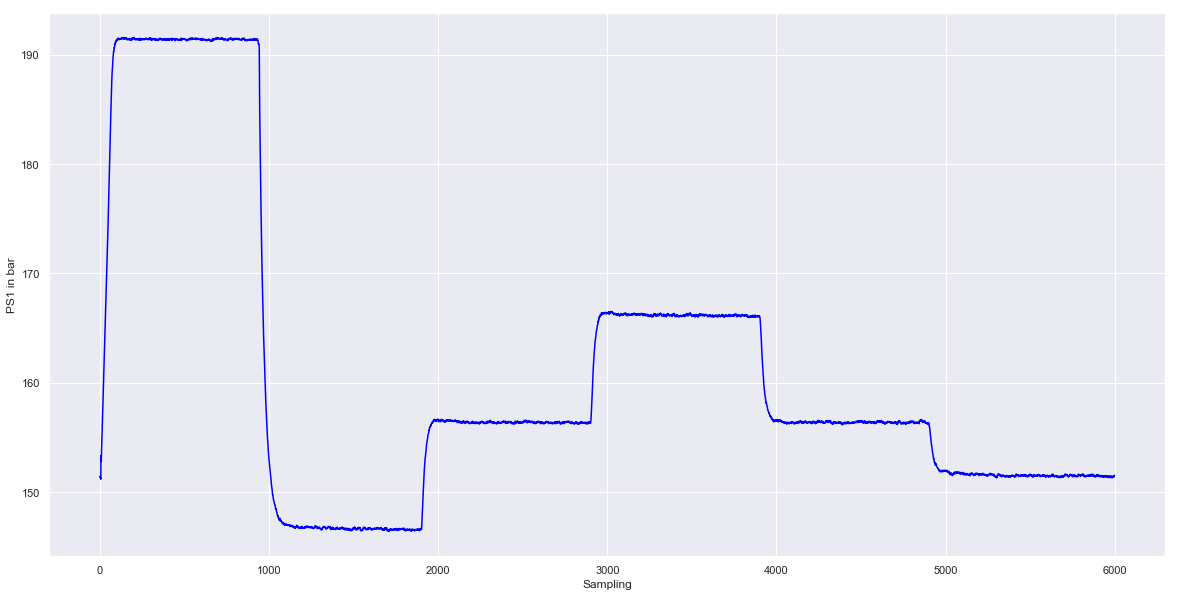

1


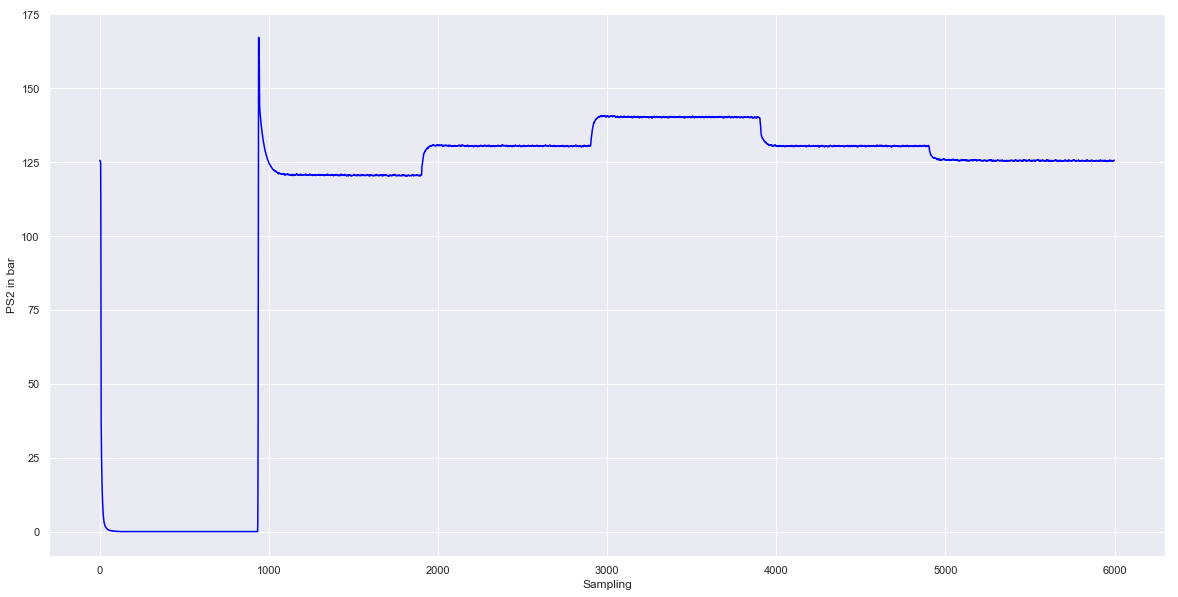

2


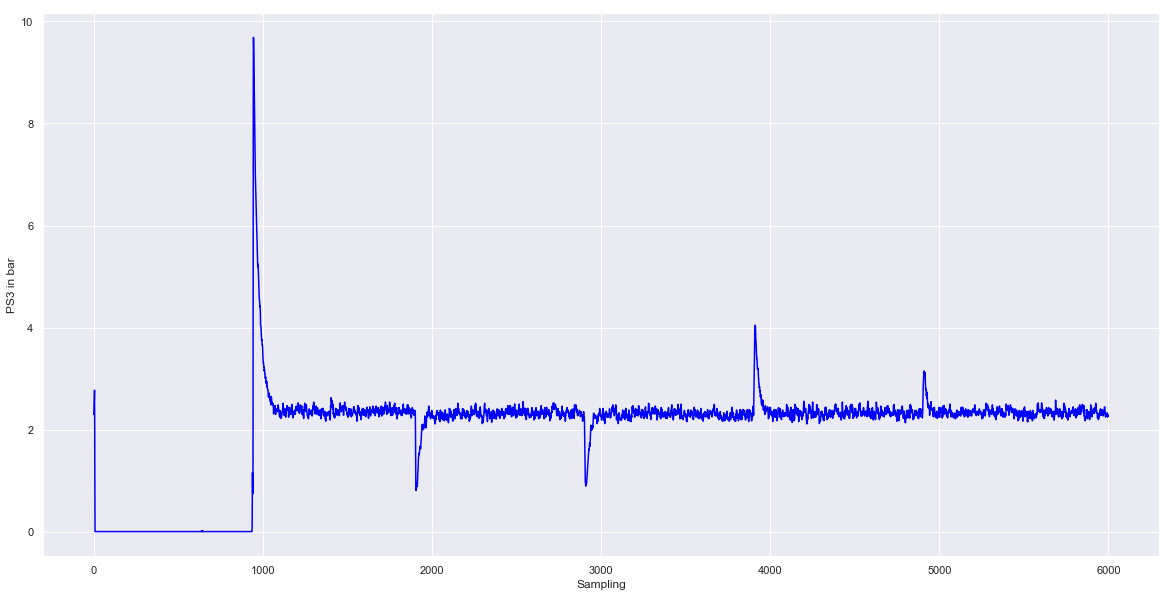

3


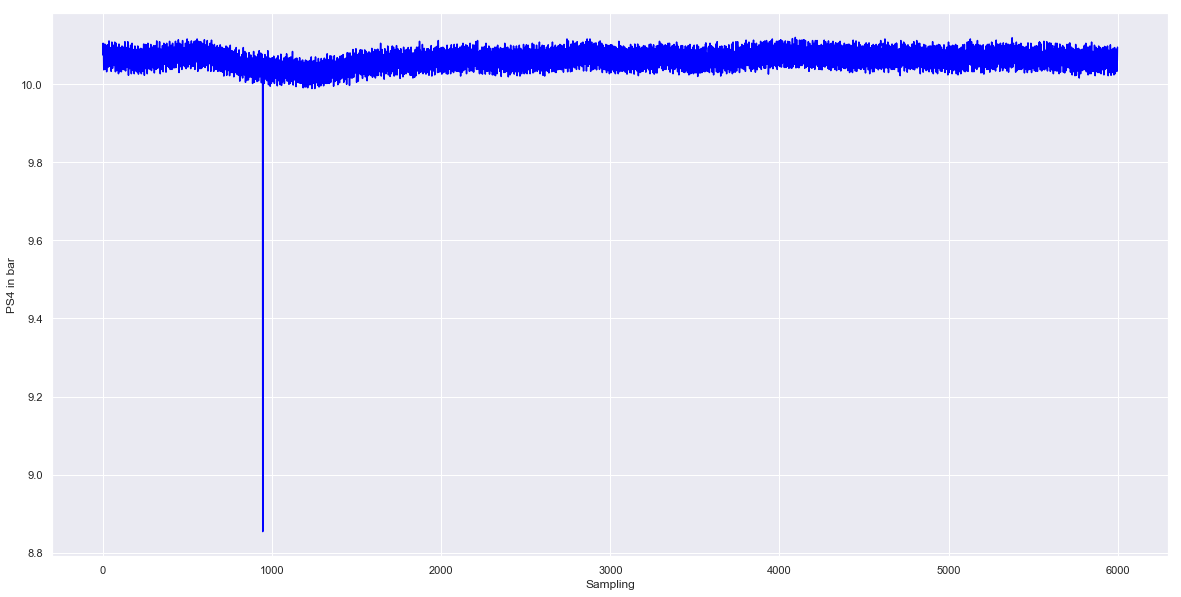

4


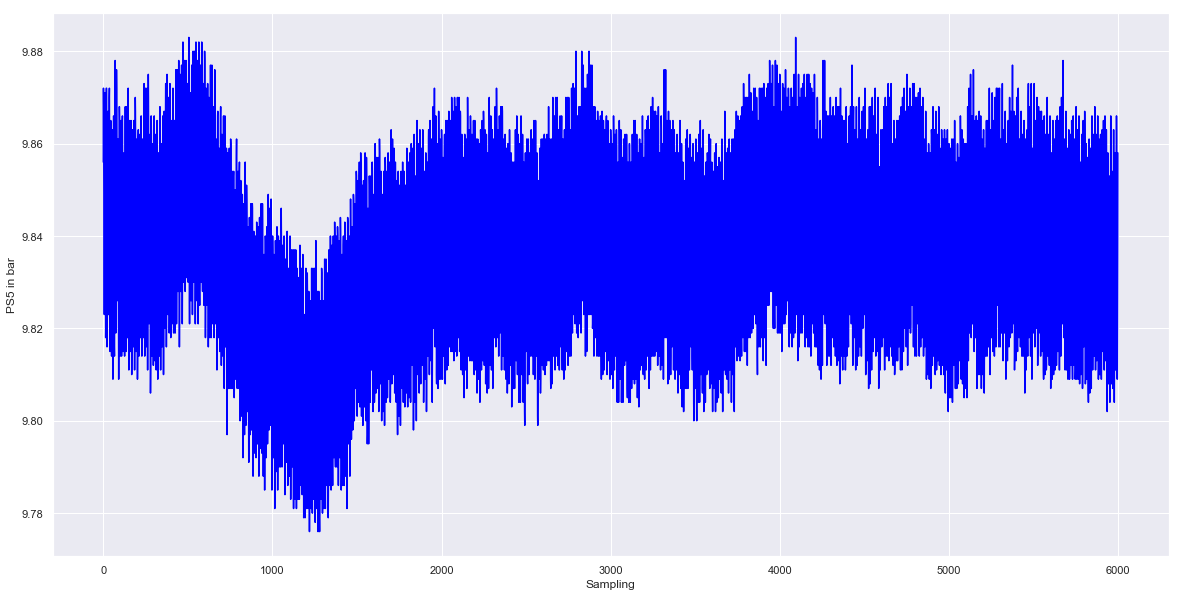

5


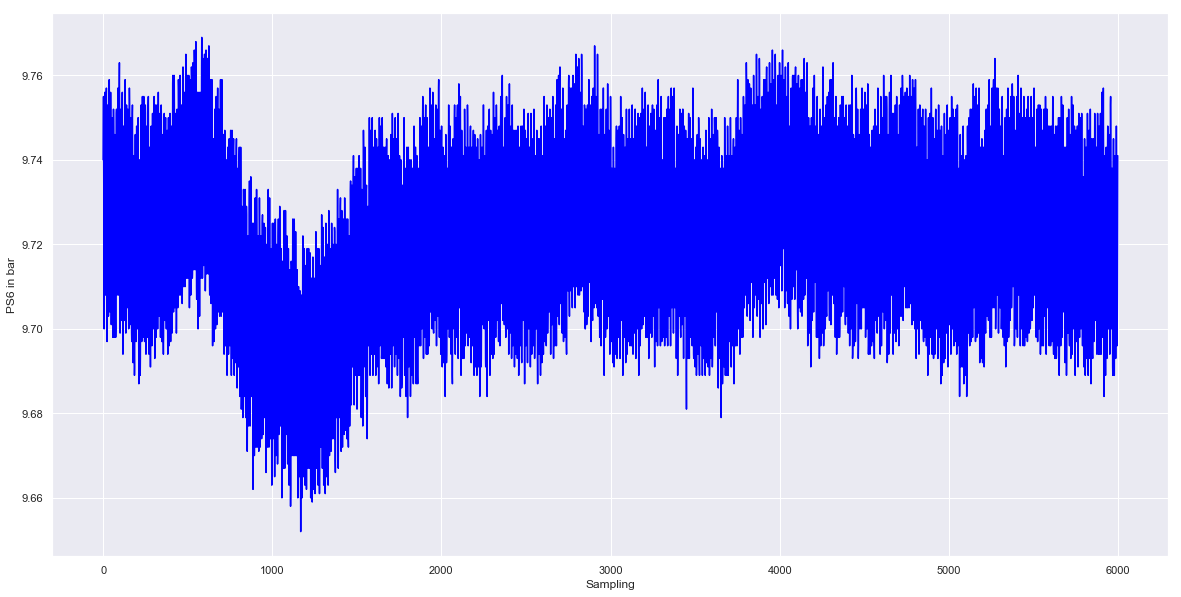

6


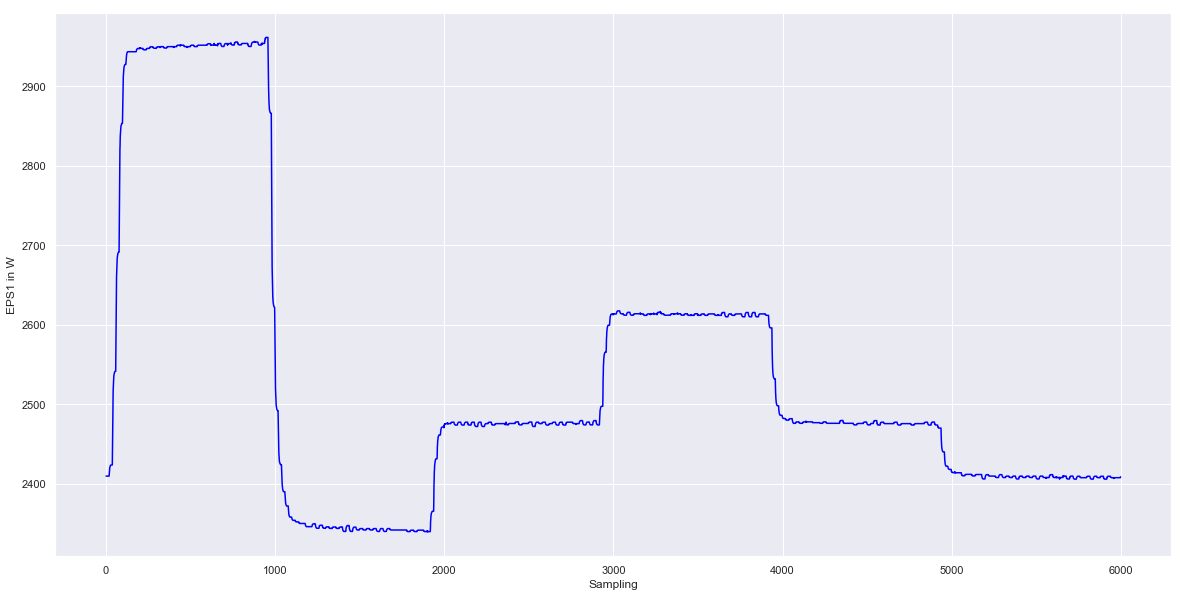

7


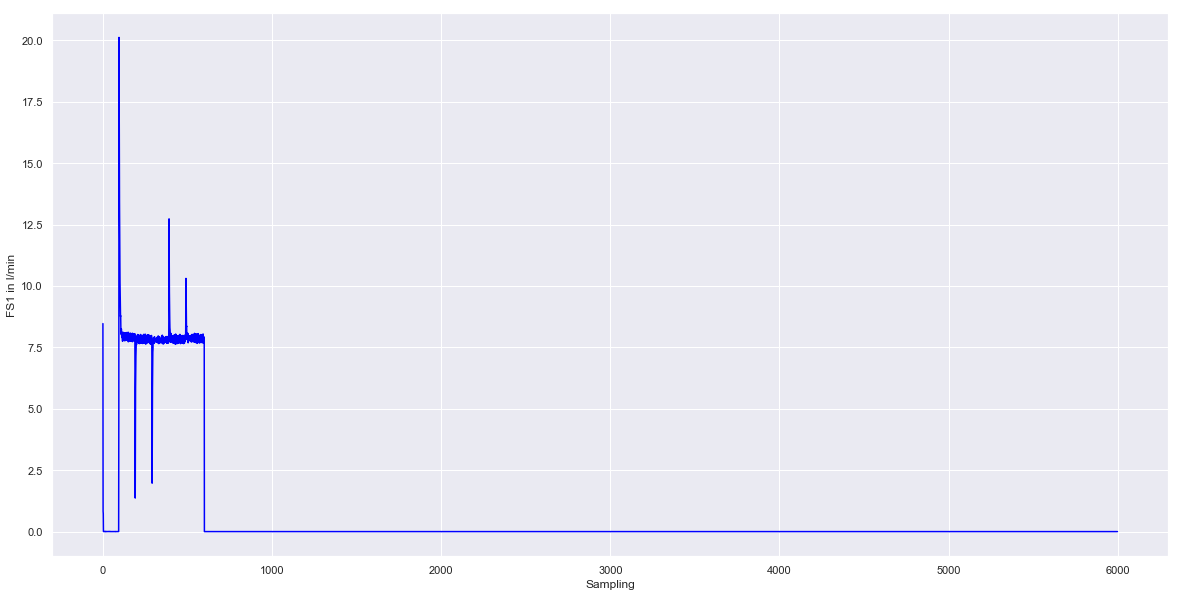

8


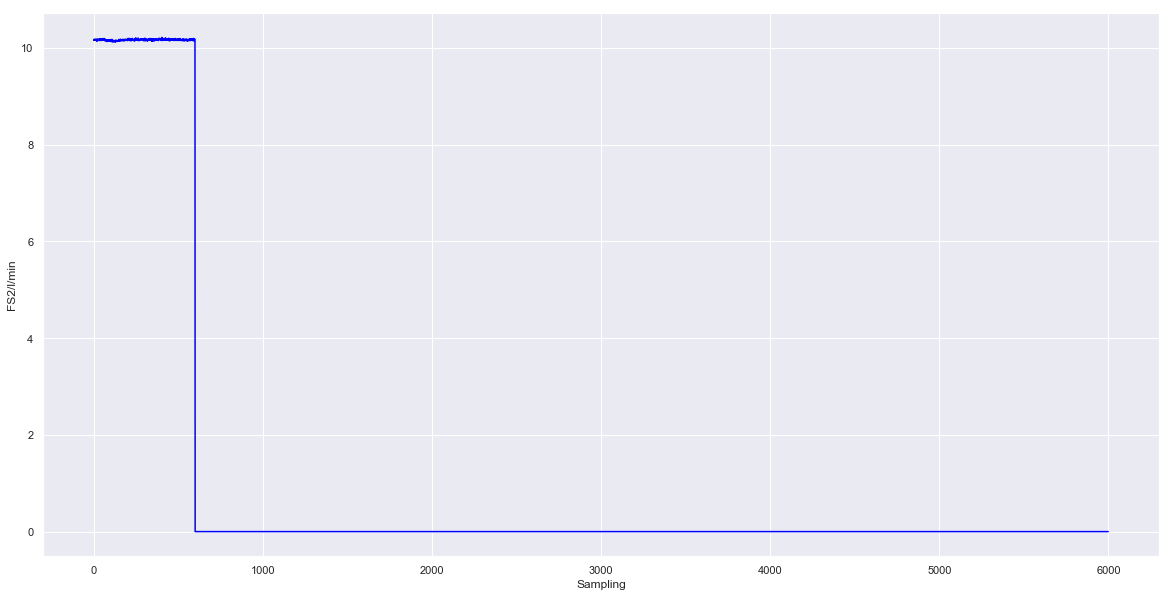

9


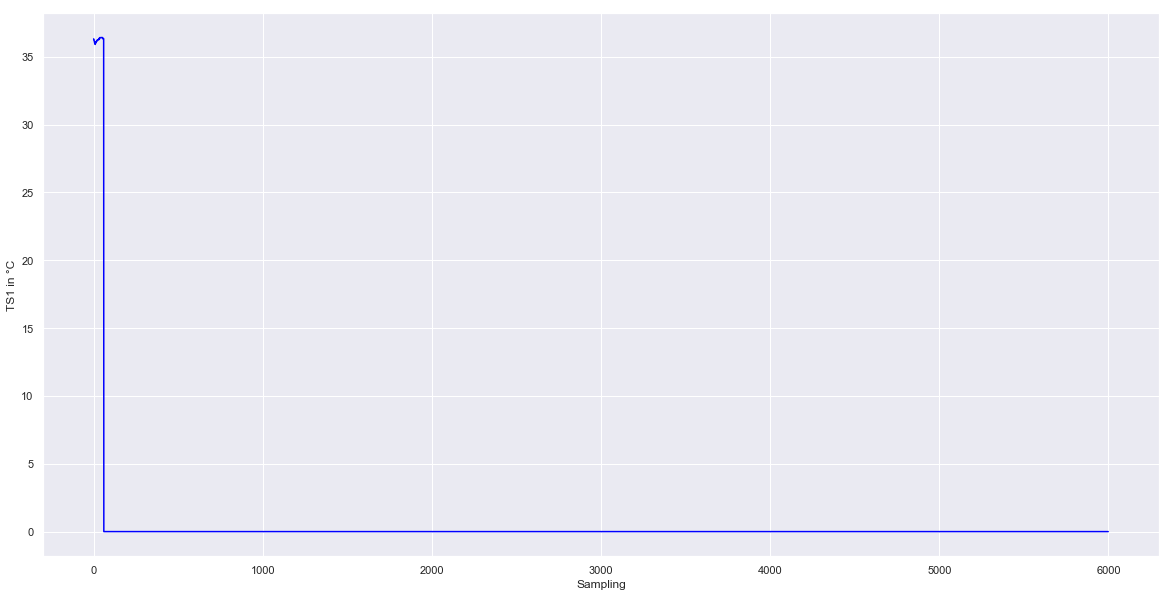

10


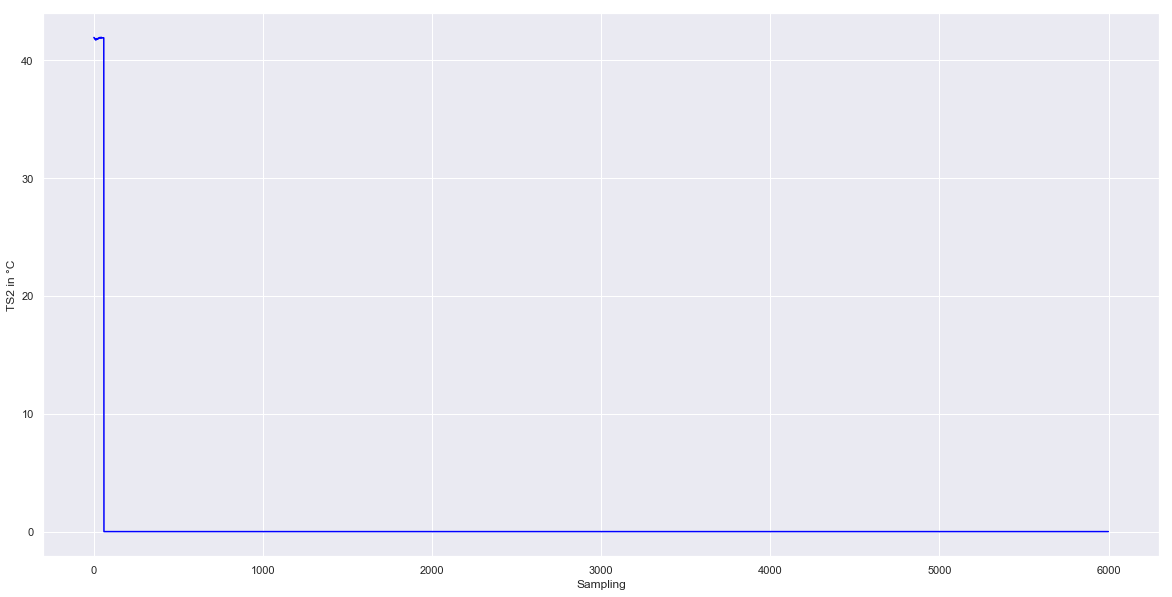

11


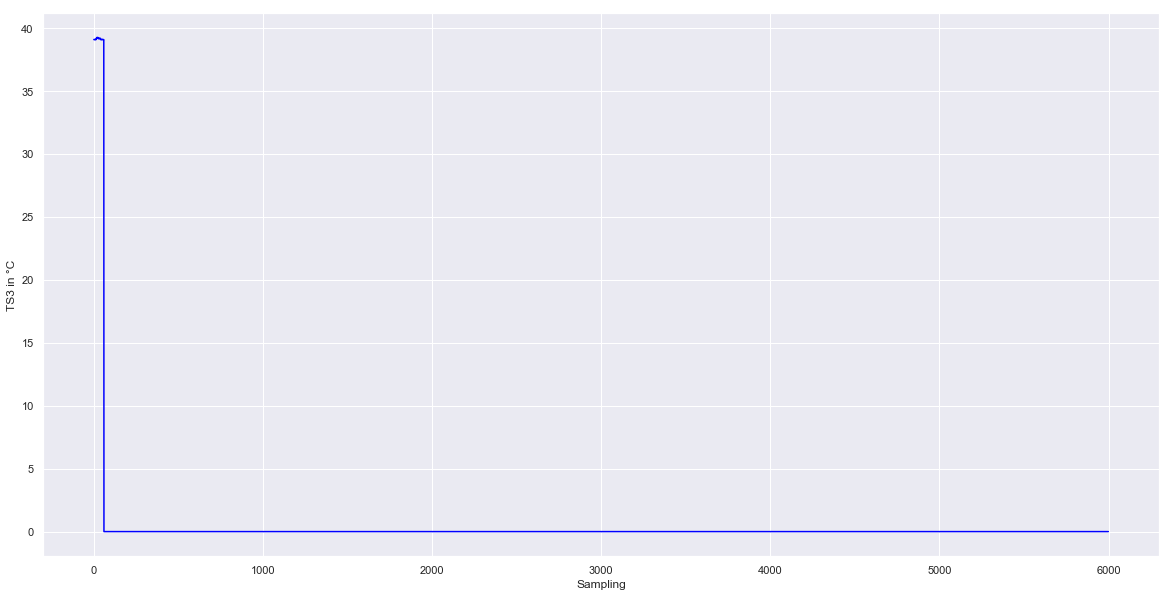

12


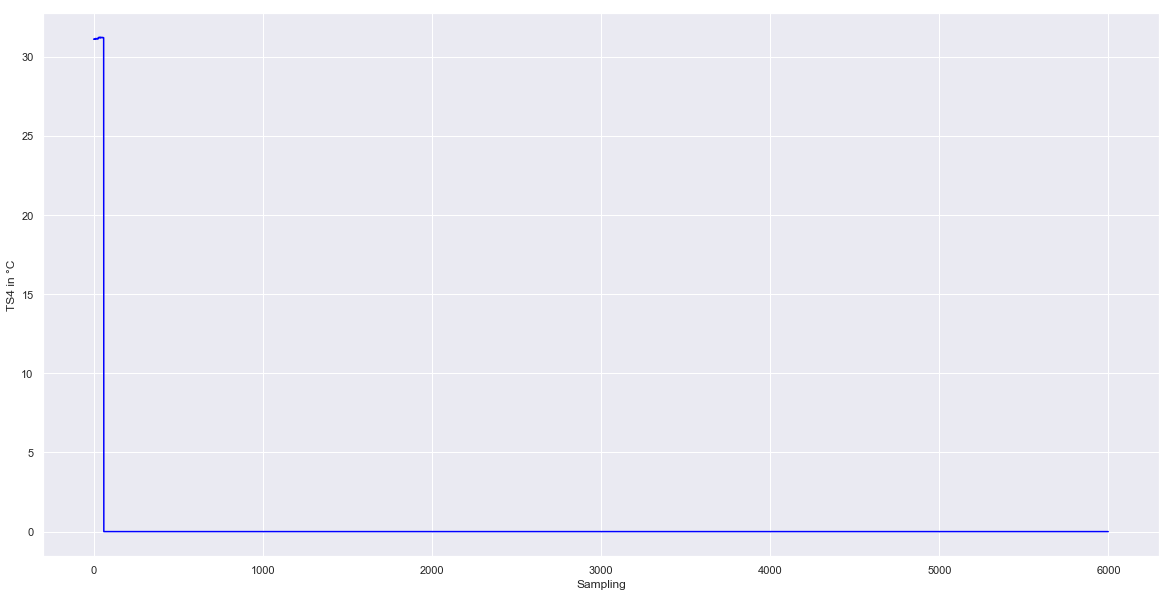

13


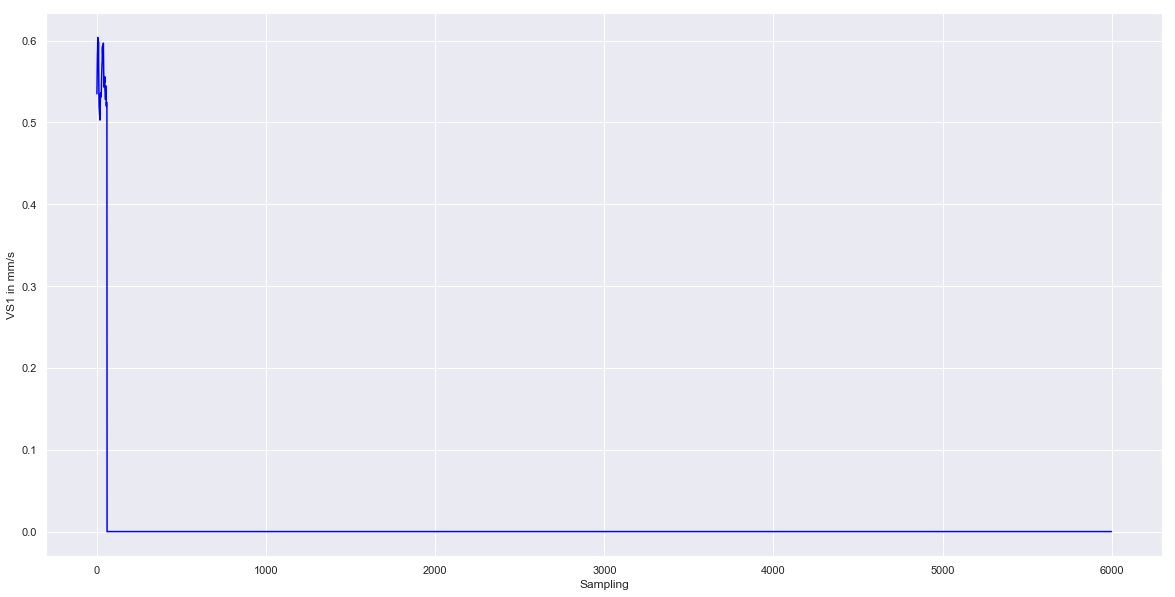

14


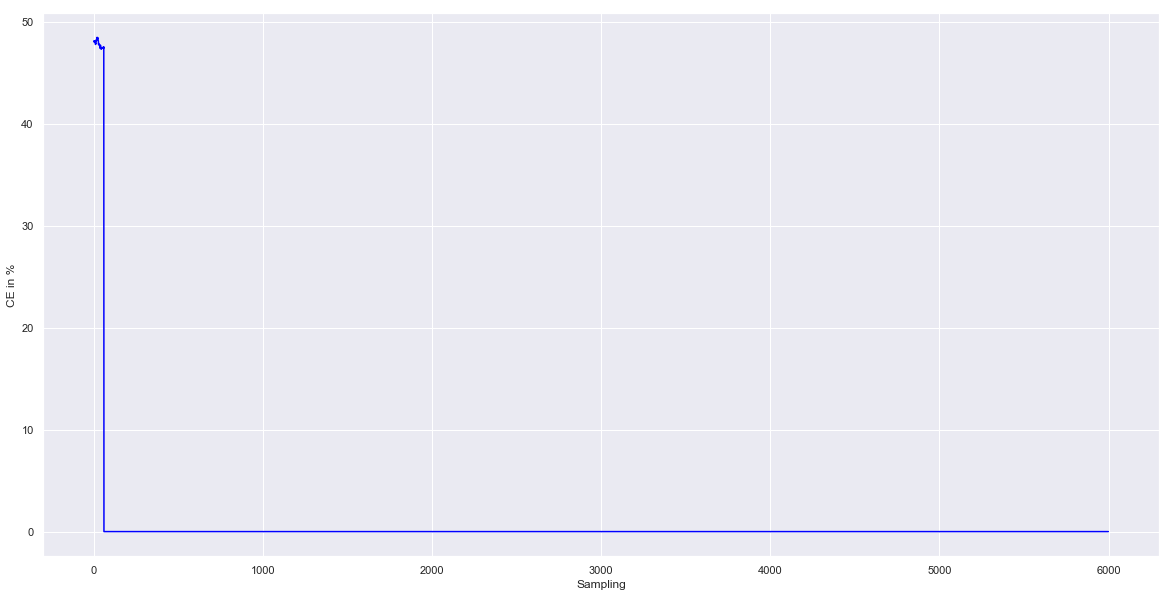

15


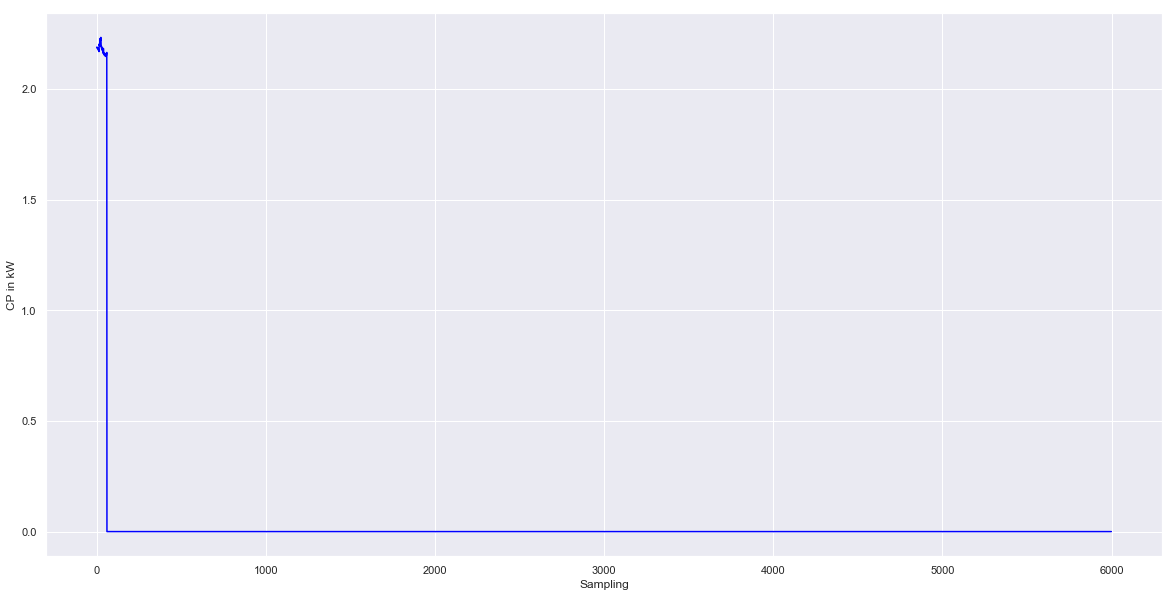

16


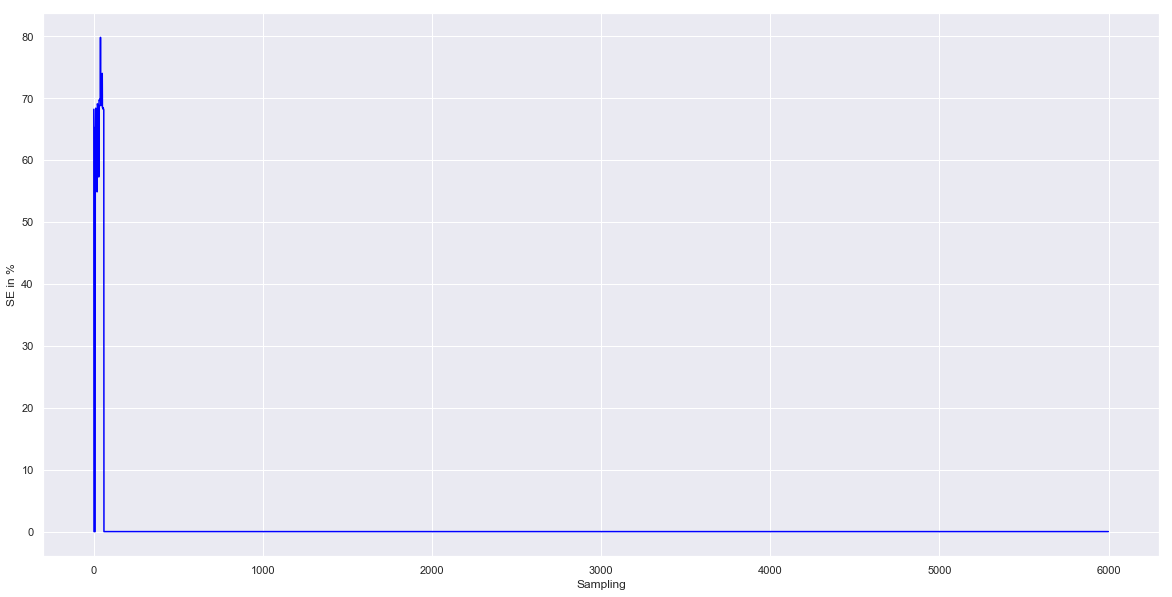

In [49]:
#plot features
feature_name_list = ["PS1 in bar", "PS2 in bar", "PS3 in bar", "PS4 in bar", "PS5 in bar", "PS6 in bar", "EPS1 in W", "FS1 in l/min", "FS2/l/min",
                    "TS1 in °C", "TS2 in °C", "TS3 in °C", "TS4 in °C", "VS1 in mm/s", "CE in %", "CP in kW", "SE in %"]

#feature_unit_list = ["100Hz", "100Hz", "100Hz", "100Hz", "100Hz", "100Hz", "100Hz", "10Hz", "10hz",
#                    "1Hz", "1Hz", "1Hz", "1Hz", "1Hz", "1Hz", "1Hz", "1Hz"]


#for key in all_key_list:
 #   print(key)

    
train_key = ['c100_h130_pl0_v100_s0']
#print(all_key_list[0])

#pp = PdfPages('case02.pdf')
for i in range(0,17):
    
    print(i)
    plt.figure(figsize=(20,10))
    #plt.title(all_key_list[0])
        #plt.plot(y_scaled_predictions_vanilla_dict[train_key], color="")
    plt.plot(X_full_staked_tensor[all_key_list[0]][:6000,0,i], color="blue")
    #plt.plot(X_full_staked_tensor[all_key_list[2]][:,0,i], color="blue")
    #plt.plot(X_full_staked_tensor[all_key_list[2]][:,0,i], color="orange")
    #plt.plot(X_full_staked_tensor[all_key_list[3]][:,0,i], color="red")
    #plt.plot(X_full_staked_tensor[all_key_list[4]][:,0,i], color="yellow")
    #plt.plot(X_full_staked_tensor[all_key_list[5]][:,0,i], color="purple")
    #plt.plot(X_full_staked_tensor[all_key_list[6]][:,0,i], color="black")
    #plt.plot(X_full_staked_tensor[all_key_list[7]][:,0,i], color="brown")
    #plt.plot(X_full_staked_tensor[all_key_list[8]][:,0,i], color="pink")
        #plt.plot(X_scaled_full_staked_tensor["c3_h130_pl0_v100_s0"][:,0,i], color="red")
        #plt.plot(X_scaled_full_staked_tensor["c100_h130_pl0_v100_s0"][:,0,i], color="red")
    plt.ylabel(feature_name_list[i])
    plt.xlabel("Sampling")
    plt.grid(True)
#    pp.savefig()
    #plt.savefig("C:\\Users\\mooc\\Documents\\Bosch-MT\\Thesis-Templates\\latex-templates-master\\thesis\\figures\\feature%s.png" %(feature_list[i]), format="png")
    plt.show()

#pp.close()   


### Vanilla LSTM 

In [92]:
pp.close()

AttributeError: 'NoneType' object has no attribute 'finalize'

In [34]:
init = RandomUniform(minval=-0.05, maxval=0.05)

#path_checkpoint = '23_checkpoint_h256_s50.keras'
path_checkpoint = 'test'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-5,
                                       patience=0,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [35]:
#define model
n_features=X_full_staked_tensor['c100_h130_pl0_v100_s0'].shape[2]
n_output_features = 1
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
print(n_features)

model_vanilla = Sequential()
model_vanilla.add(LSTM(256, activation='relu', input_shape=(n_steps, n_features)))
model_vanilla.add(Dense(1, activation='linear',
                    kernel_initializer=init))
### load weights from pretrained model
#model_vanilla.load_weights("23_checkpoint.keras")
###
model_vanilla.compile(optimizer=adam, loss='mse')

17


In [36]:
y_scaled_full_staked_tensor['c100_h130_pl0_v100_s0'][:,0].shape

(59950,)

In [37]:
# fit model
#X_scaled_full_stacked_leakage0_train_tensor, y_scaled_full_stacked_leakage0_train_tensor
train_key = 'c100_h130_pl0_v100_s0'
test_key = 'c100_h130_pl1_v100_s0'

start_time = datetime.datetime.now() 

model_vanilla.fit(X_scaled_full_staked_tensor[train_key], y_scaled_full_staked_tensor[train_key][:,0:1],
                  epochs=50,
                  batch_size=1,
                  verbose=1,
                  validation_data=(X_scaled_full_staked_tensor[test_key], y_scaled_full_staked_tensor[test_key][:,0:1]),
                  shuffle=False,
                  callbacks=callbacks)
#reset model to learn from beginning
#model_vanilla.reset_states()

time_elapsed = datetime.datetime.now() - start_time 
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

Train on 59950 samples, validate on 59950 samples
Epoch 1/50
59950/59950 [==============================] - 3090s 52ms/step - loss: 1.8245e-04 - val_loss: 0.0478

Epoch 00001: val_loss improved from inf to 0.04778, saving model to test
Epoch 2/50
59950/59950 [==============================] - 3165s 53ms/step - loss: 4.8303e-05 - val_loss: 0.0063

Epoch 00002: val_loss improved from 0.04778 to 0.00635, saving model to test
Epoch 3/50
59950/59950 [==============================] - 3180s 53ms/step - loss: 3.4495e-05 - val_loss: 0.0185

Epoch 00003: val_loss did not improve from 0.00635

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/50
59950/59950 [==============================] - 2037s 34ms/step - loss: 5.1444e-05 - val_loss: 0.0014

Epoch 00004: val_loss improved from 0.00635 to 0.00139, saving model to test
Epoch 5/50
59950/59950 [==============================] - 1926s 32ms/step - loss: 1.1432e-05 - val_loss: 0.0029

Epoch 00005: val_loss did

KeyboardInterrupt: 

In [25]:
#reset hidden state and model
#model_vanilla.reset_states()

In [ ]:
# 5 epochs are not enough, training loss and validation loss still decrease -> more epochs approx 12 epochs

In [54]:
y_scaled_predictions_vanilla_dict = {}
y_scaled_predictions_vanilla_dict[train_key] = model_vanilla.predict(X_scaled_full_staked_tensor[train_key], verbose=1)
y_scaled_predictions_vanilla_dict[test_key] = model_vanilla.predict(X_scaled_full_staked_tensor[test_key], verbose=1)

59950/59950 [==============================] - 33s 555us/step


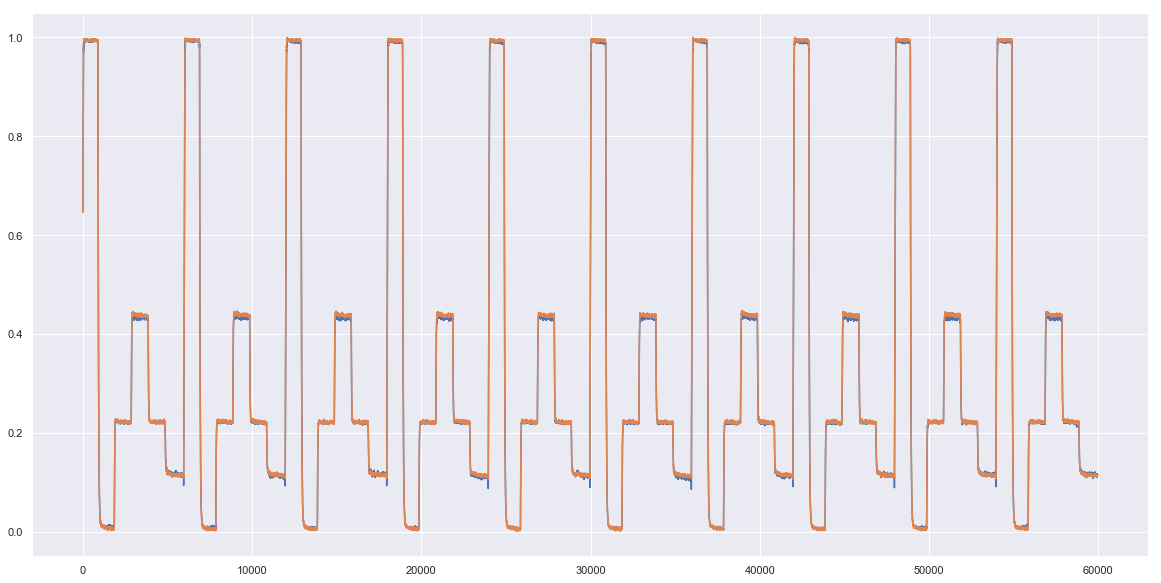

In [133]:

plt.figure(figsize=(20,10))
plt.plot(y_scaled_predictions_vanilla_dict[train_key])
plt.plot(y_scaled_full_staked_tensor[train_key][:,0])
#plt.plot(y_scaled_full_staked_tensor[test_key][:,0])
#plt.plot(y_scaled_predictions_vanilla_dict[test_key])
plt.show()

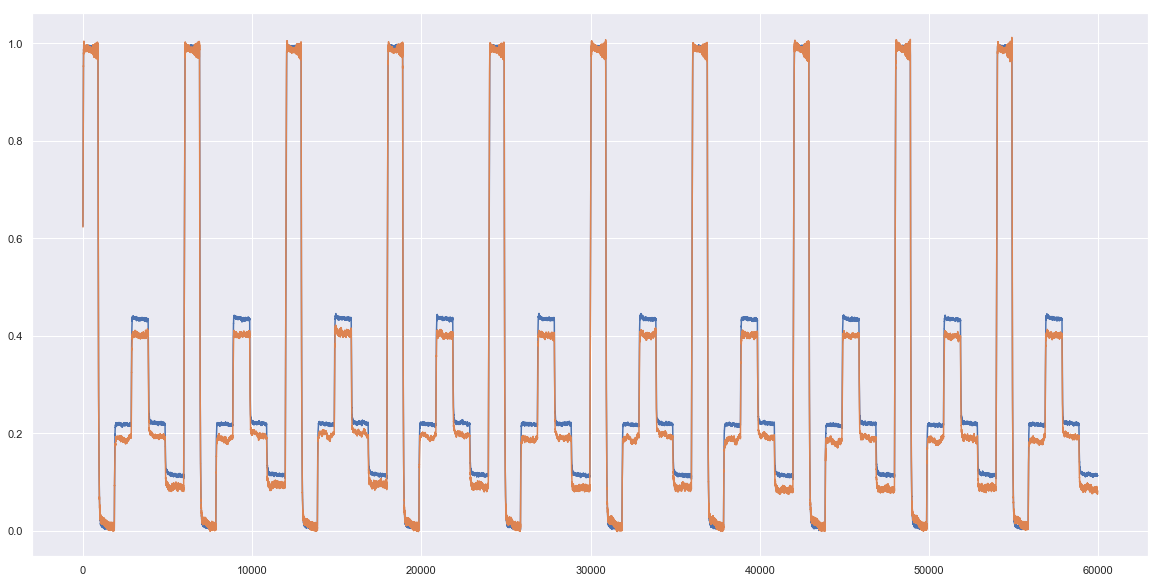

In [61]:
plt.figure(figsize=(20,10))
#plt.plot(y_scaled_predictions_vanilla_dict[train_key])
#plt.plot(y_scaled_full_staked_tensor[train_key][:,0])
plt.plot(y_scaled_full_staked_tensor[test_key][:,0])
plt.plot(y_scaled_predictions_vanilla_dict[test_key])
plt.show()

In [51]:
feature_name_list = ["PS1/bar", "PS2/bar", "PS3/bar", "PS4/bar", "PS5/bar", "PS6/bar", "EPS1/W", "FS1/l/min", "FS2/l/min",
                    "TS1/°C", "TS2/°C", "TS3/°C", "TS4/°C", "VS1/mm/s", "CE/%", "CP/kW", "SE/%"]

feature_unit_lits = ["100Hz", "100Hz", "100Hz", "100Hz", "100Hz", "100Hz", "100Hz", "10Hz", "10hz",
                    "1Hz", "1Hz", "1Hz", "1Hz", "1Hz", "1Hz", "1Hz", "1Hz"]
if False:
    for i in range(0,17):
        print(i)
        plt.figure(figsize=(20,10))
        #print(test_full_scaled_feature_tensor.shape)
        #print(test_full_scaled_feature_tensor)
        #print(X_full_staked_tensor['c100_h130_pl0_v100_s0'])

        plt.plot(y_scaled_predictions_vanilla_dict[train_key], color="blue")
        plt.plot(X_scaled_full_staked_tensor[train_key][:,0,i], color="orange")
        plt.ylabel(feature_name_list[i])
        plt.ylabel(feature_unit_list[i])
        plt.grid(True)
        plt.savefig('%s.eps' %(feature_name_list[i]), format='eps', dpi=1000)
        plt.show()

In [84]:
# invert scaling for forecast
rescaled_prediction_tensor = {}
rescaled_prediction_tensor['test_key'] = yscaler.inverse_transform(y_scaled_predictions_vanilla_dict[test_key])

ValueError: non-broadcastable output operand with shape (59990,1) doesn't match the broadcast shape (59990,17)

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(y_scaled_full_staked_tensor[test_key][:,0])
plt.plot(scaled_predictions_vanilla_dict[test_key][:,0])
plt.show()

In [ ]:
scaled_predictions_vanilla_dict = {}
train_key = 'c100_h130_pl0_v100_s0'
cnt = 1
print(X_scaled_full_staked_tensor[pred_key].shape)
print(len(tensor_dict.keys()))

In [ ]:
#prediction
scaled_predictions_vanilla_dict = {}

for predict_key in tensor_dict.keys():
    if predict_key != train_key:
        print(predict_key, cnt)
        cnt +=1 
        scaled_predictions_vanilla_dict[predict_key] = model_vanilla.predict(X_scaled_full_staked_tensor[predict_key], verbose=1)
    else:
        print("train key skipped")
        continue

        
# invert predictions
#for predict_key in tensor_dict.keys():
#    if predict_key != train_key:
#            trainPredict = scaler.inverse_transform(trainPredict)
#            trainY = scaler.inverse_transform([trainY])
#            testPredict = scaler.inverse_transform(testPredict)
#            testY = scaler.inverse_transform([testY])        

In [ ]:

#print(X_scaled_full_staked_tensor['c20_h90_pl0_v100_s0'].shape)
#print(y_scaled_full_staked_tensor['c20_h90_pl0_v100_s0'][0:10,0])
#print(scaled_predictions_vanilla_dict['c20_h90_pl0_v100_s0'][,0])

In [ ]:
y_scaled_full_staked_tensor['c20_h90_pl0_v100_s0']

In [ ]:
predkey='c100_h130_pl1_v100_s0'
plot_cycles_all_features(y_scaled_full_staked_tensor, predkey)
plot_cycles_all_features(scaled_predictions_vanilla_dict, predkey)

### Stacked LSTM

In [43]:
stacked_init = RandomUniform(minval=-0.05, maxval=0.05)

stacked_path_checkpoint = 'stacked_checkpoint_2l_h128_s50_f17.keras'
stacked_callback_checkpoint = ModelCheckpoint(filepath=stacked_path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

stacked_callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

stacked_callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=True)

stacked_callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-7,
                                       patience=0,
                                       verbose=1)

stacked_callbacks = [stacked_callback_early_stopping,
             stacked_callback_checkpoint,
             stacked_callback_tensorboard,
             stacked_callback_reduce_lr]

In [52]:
# stacked LSTM
n_features=X_full_staked_tensor['c100_h130_pl0_v100_s0'].shape[2]
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
n_output_features = 1


model_stacked = Sequential()
model_stacked.add(LSTM(512, activation='relu', input_shape=(n_steps, n_features), return_sequences=False))
#model_stacked.add(Dropout(0.8))
#model_stacked.add(LSTM(512, activation='relu', input_shape=(n_steps, n_features), return_sequences=False))
#model_stacked.add(Dropout(0.8))
model_stacked.add(Dense(17, activation='linear',
                    kernel_initializer=stacked_init))
#model_stacked.add(Activation(1, activation='linear',
                   # kernel_initializer=stacked_init))
model_stacked.compile(optimizer=adam, loss='mse')

In [53]:
start_time = datetime.datetime.now() 

#y_scaled_full_staked_tensor[train_key][:,0]

model_stacked.fit(X_scaled_full_staked_tensor[train_key], y_scaled_full_staked_tensor[train_key][:,:], 
                  epochs=50, verbose=1, 
                  validation_data=(X_scaled_full_staked_tensor[test_key], y_scaled_full_staked_tensor[test_key][:,:]),
                  shuffle = False,
                  callbacks = stacked_callbacks
                  )
time_elapsed = datetime.datetime.now() - start_time 
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))
print(model_stacked.)

Train on 59950 samples, validate on 59950 samples
Epoch 1/50
59950/59950 [==============================] - 852s 14ms/step - loss: 153186831.8870 - val_loss: 171548.4200

Epoch 00001: val_loss did not improve from 0.02973
Epoch 2/50
59950/59950 [==============================] - 868s 14ms/step - loss: 91195693.6439 - val_loss: 0.0311

Epoch 00002: val_loss did not improve from 0.02973
Epoch 3/50
59950/59950 [==============================] - 873s 15ms/step - loss: 0.5450 - val_loss: 0.0222

Epoch 00003: val_loss improved from 0.02973 to 0.02222, saving model to stacked_checkpoint_2l_h128_s50_f17.keras
Epoch 4/50
59950/59950 [==============================] - 927s 15ms/step - loss: 0.0123 - val_loss: 0.0215

Epoch 00004: val_loss improved from 0.02222 to 0.02145, saving model to stacked_checkpoint_2l_h128_s50_f17.keras
Epoch 5/50
59950/59950 [==============================] - 923s 15ms/step - loss: 0.0107 - val_loss: 0.0160

Epoch 00005: val_loss improved from 0.02145 to 0.01597, saving

### Serialize and load Model to JSON

In [ ]:
# serialize model to JSON
model_vanilla_json = model_vanilla.to_json()
model_file ="model_vanilla.json"
weight_file = "model_vanilla.h5"
file = os.path.join(path, model_file)
weights = os.path.join(path, weight_file)

with open(file, "w") as json_file:
    json_file.write(model_vanilla_json)

# serialize weights to HDF5
model_vanilla.save_weights(weights)
print("Saved model to disk")

In [ ]:
# load json and create model
json_file = open(file, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weights)
print("Loaded model from disk")

In [ ]:
#leackeage
#n_steps=10
#X_full_stacked_leackage0_train_tensor, y_full_stacked_leackage0_train_tensor = transform_data_for_LSTM(leackage0_train_tensor[:,:,0:17], n_steps=n_steps)
#X_full_stacked_leackage1_test_tensor, y_full_stacked_leackage1_test_tensor = transform_data_for_LSTM(leackage1_test_tensor[:,:,0:17], n_steps=n_steps)
#X_full_stacked_leackage2_test_tensor, y_full_stacked_leackage2_test_tensor = transform_data_for_LSTM(leackage2_test_tensor[:,:,0:17], n_steps=n_steps)

### Vanilla LSTM one Feature

In [24]:
init_1 = RandomUniform(minval=-0.05, maxval=0.05)

path_checkpoint_1 = '23_checkpoint_h512_s50_PS1.keras'
callback_checkpoint_1 = ModelCheckpoint(filepath=path_checkpoint_1,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping_1 = EarlyStopping(monitor='val_loss',
                                        patience=10, verbose=1)

callback_tensorboard_1 = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

callback_reduce_lr_1 = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-7,
                                       patience=0,
                                       verbose=1)

callbacks_1 = [callback_early_stopping_1,
             callback_checkpoint_1,
             callback_tensorboard_1,
             callback_reduce_lr_1]

In [25]:
#define model
#n_features=X_full_staked_tensor_1['c100_h130_pl0_v100_s0'].shape[2]
n_features=1
n_output_features = 1
adam_1 = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
print(n_features)

model_vanilla_1 = Sequential()
model_vanilla_1.add(LSTM(512, activation='relu', input_shape=(n_steps, n_features)))
model_vanilla_1.add(Dense(1, activation='linear',
                    kernel_initializer=init_1))
### load weights from pretrained model
model_vanilla_1.load_weights("23_checkpoint_h512_s50_PS1.keras")
###
model_vanilla_1.compile(optimizer=adam_1, loss='mse')

1


In [ ]:
# fit model
#X_scaled_full_stacked_leakage0_train_tensor, y_scaled_full_stacked_leakage0_train_tensor

if False:
    train_key = 'c100_h130_pl0_v100_s0'
    test_key = 'c100_h130_pl1_v100_s0'

    start_time = datetime.datetime.now() 

    model_vanilla_1.fit(X_scaled_full_staked_tensor[train_key][:,:,0:1], y_scaled_full_staked_tensor[train_key][:,0],
                  epochs=50,
                  batch_size=1,
                  verbose=1,
                  validation_data=(X_scaled_full_staked_tensor[test_key][:,:,0:1], y_scaled_full_staked_tensor[test_key][:,0]),
                  shuffle=False,
                  callbacks=callbacks_1)
    #reset model to learn from beginning
    #model_vanilla.reset_states()

    time_elapsed = datetime.datetime.now() - start_time 
    print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

Train on 59950 samples, validate on 59950 samples
Epoch 1/50
59950/59950 [==============================] - 6933s 116ms/step - loss: 1.6968e-04 - val_loss: 0.1691

Epoch 00001: val_loss improved from inf to 0.16908, saving model to 23_checkpoint_h512_s50_PS1.keras
Epoch 2/50
59950/59950 [==============================] - 7116s 119ms/step - loss: 5.3935e-05 - val_loss: 0.1458

Epoch 00002: val_loss improved from 0.16908 to 0.14578, saving model to 23_checkpoint_h512_s50_PS1.keras
Epoch 3/50
59950/59950 [==============================] - 7279s 121ms/step - loss: 5.4967e-05 - val_loss: 0.1200

Epoch 00003: val_loss improved from 0.14578 to 0.12000, saving model to 23_checkpoint_h512_s50_PS1.keras
Epoch 4/50
59950/59950 [==============================] - 7044s 118ms/step - loss: 6.7739e-05 - val_loss: 0.1034

Epoch 00004: val_loss improved from 0.12000 to 0.10338, saving model to 23_checkpoint_h512_s50_PS1.keras
Epoch 5/50
59950/59950 [==============================] - 7321s 122ms/step - l

In [26]:
y_scaled_predictions_vanilla_dict_1 = {}

for key in X_scaled_full_staked_tensor.keys():
    y_scaled_predictions_vanilla_dict_1[key] = model_vanilla_1.predict(X_scaled_full_staked_tensor[key][:,:,0:1], verbose=1)
#y_scaled_predictions_vanilla_dict_1[test_key] = model_vanilla_1.predict(X_scaled_full_staked_tensor[test_key][:,:,0:1], verbose=1)

65950/65950 [==============================] - 339s 5ms/step


In [27]:
y_scaled_predictions_vanilla_dict_1.keys()

dict_keys(['c100_h130_pl1_v100_s0', 'c100_h130_pl0_v100_s1', 'c100_h130_pl2_v100_s0', 'c100_h130_pl0_v100_s0'])

c100_h130_pl1_v100_s0


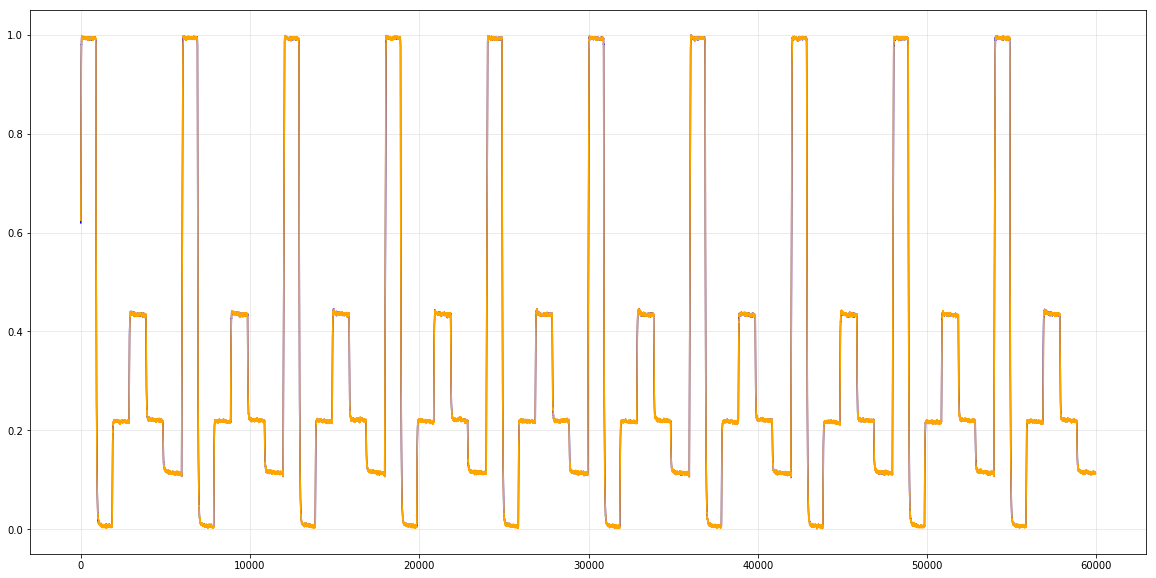

c100_h130_pl2_v100_s0


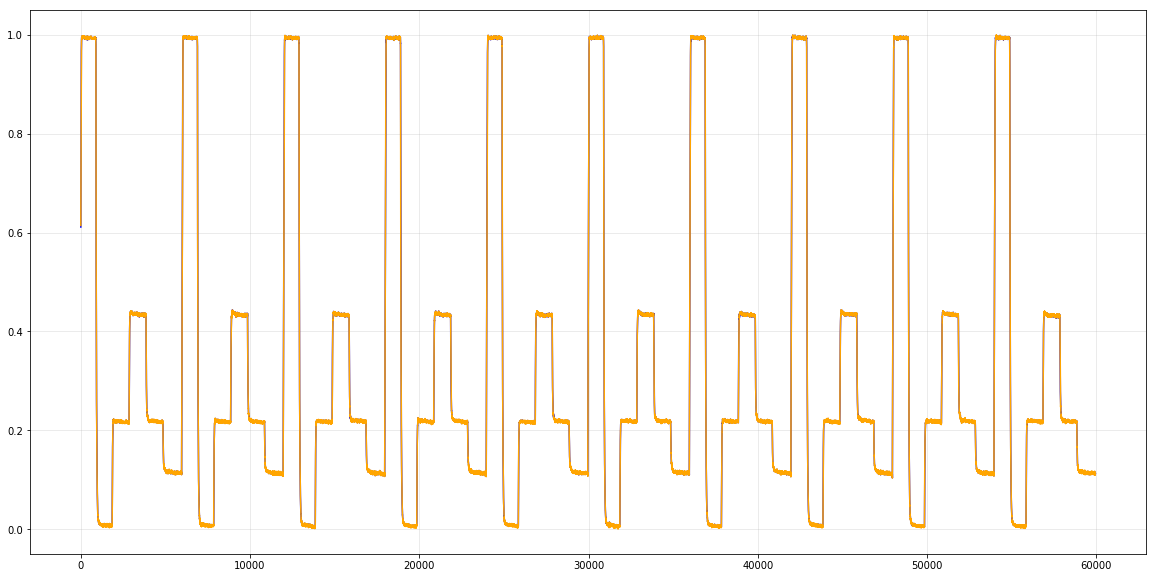

c100_h130_pl0_v100_s0


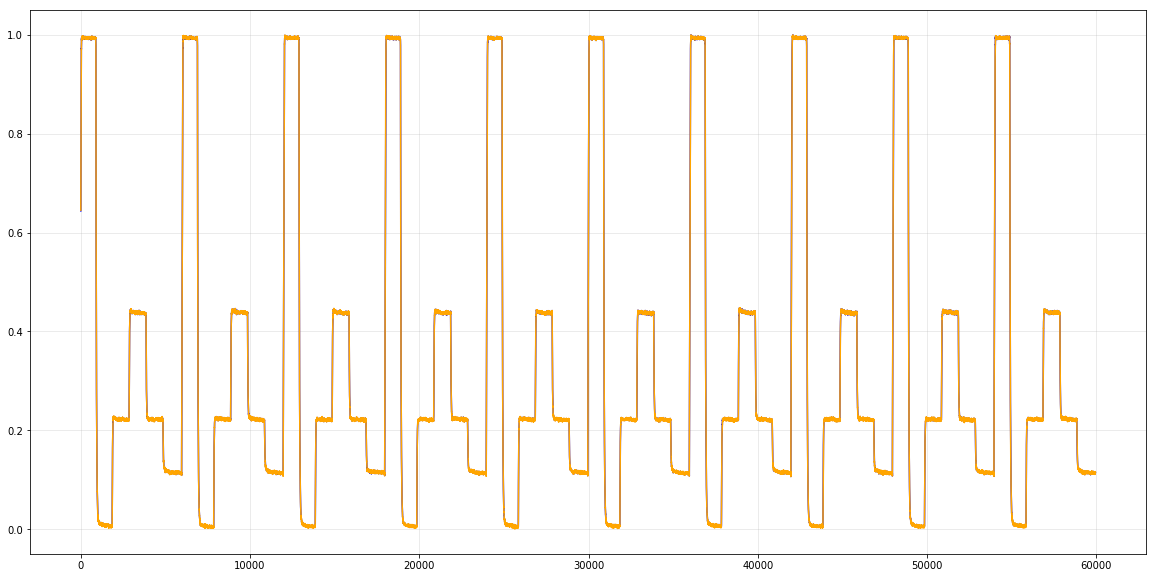

c100_h130_pl0_v100_s1


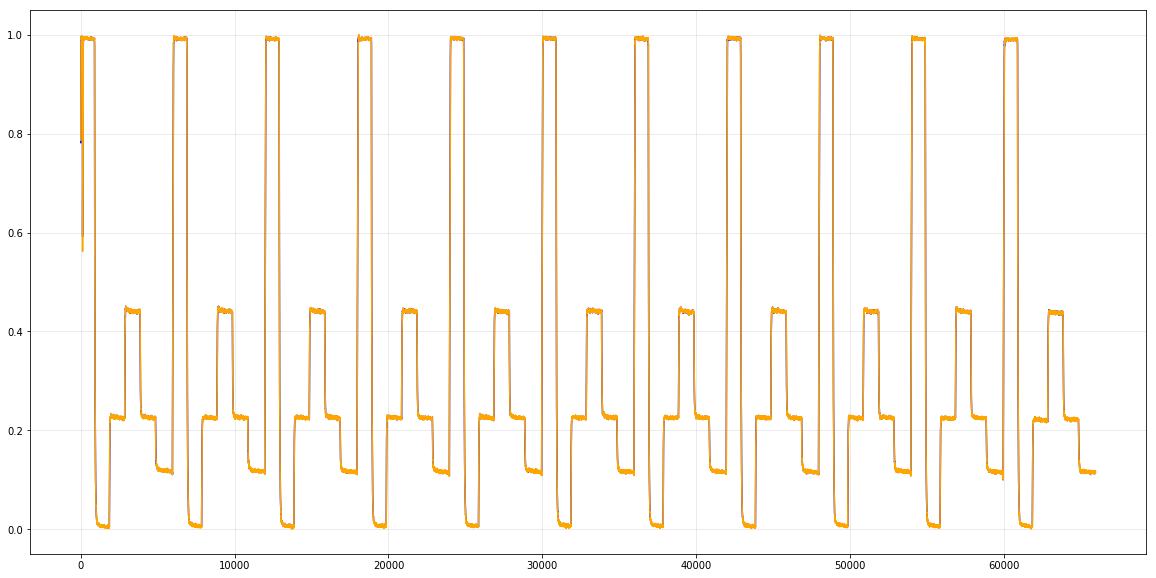

In [28]:
for key in X_scaled_full_staked_tensor.keys():
    print(key)
    plt.figure(figsize=(20,10))
    #plt.plot(y_scaled_predictions_vanilla_dict_1[train_key])
    plt.plot(y_scaled_predictions_vanilla_dict_1[key][:,0:1], color="blue")
    plt.plot(y_scaled_full_staked_tensor[key][:,0], color="orange")
    plt.grid(True, alpha=0.3)
    plt.show()

In [29]:
residuen_scaled_predictions_vanilla_dict_1 = {}

for key in X_scaled_full_staked_tensor.keys():
    residuen_scaled_predictions_vanilla_dict_1[key] = y_scaled_predictions_vanilla_dict_1[key][0:20000,0:1] - y_scaled_full_staked_tensor[key][0:20000,0]
   

KeyboardInterrupt: 

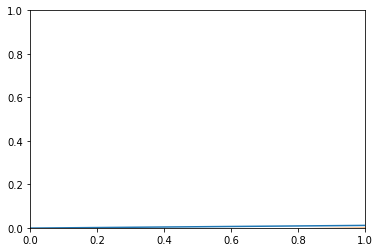

In [31]:
#test =residuen_scaled_predictions_vanilla_dict_1["c100_h130_pl0_v100_s0"][0:20000,0:1]
plt.plot(residuen_scaled_predictions_vanilla_dict_1["c100_h130_pl0_v100_s0"])
plt.show

In [32]:
print(y_scaled_predictions_vanilla_dict_1["c100_h130_pl0_v100_s1"][0:250,0:1].shape)
print(y_scaled_full_staked_tensor["c100_h130_pl0_v100_s1"][0:250,0:1].shape)
print(y_scaled_predictions_vanilla_dict_1["c100_h130_pl0_v100_s1"][0:2,0:1])
print(y_scaled_full_staked_tensor["c100_h130_pl0_v100_s1"][0:2,0:1])

#for key in X_scaled_full_staked_tensor.keys():
test_anorm = y_scaled_predictions_vanilla_dict_1["c100_h130_pl0_v100_s1"][:,0:1]-y_scaled_full_staked_tensor["c100_h130_pl0_v100_s1"][:,0:1]
test_norm = y_scaled_predictions_vanilla_dict_1["c100_h130_pl1_v100_s0"][:,0:1]-y_scaled_full_staked_tensor["c100_h130_pl1_v100_s0"][:,0:1]
#residuen_scaled_predictions_vanilla_dict_1["c100_h130_pl0_v100_s1"]

(250, 1)
(250, 1)
[[0.78213096]
 [0.7990571 ]]
[[0.78703297]
 [0.80351648]]


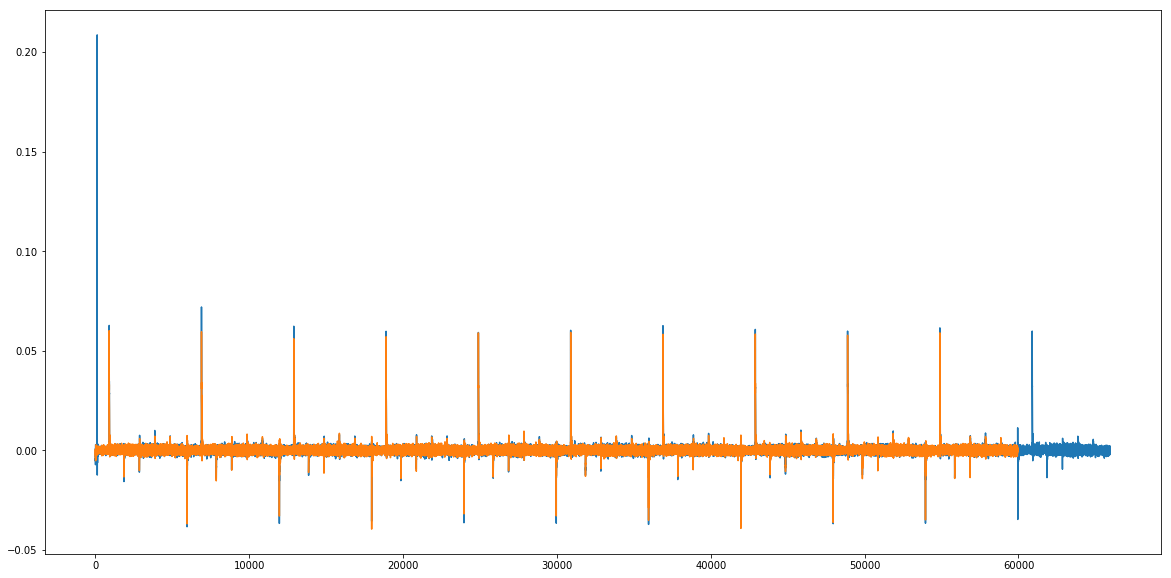

In [34]:
plt.figure(figsize=(20,10))
#plt.plot(test_anorm[0:59950] - test_norm[0:59950])
plt.plot(test_anorm)
plt.plot(test_norm)
#plt.plot(test_anorm)
#plt.plot(y_scaled_full_staked_tensor["c100_h130_pl0_v100_s1"][:,0:1], color="blue")
#plt.plot(y_scaled_predictions_vanilla_dict_1["c100_h130_pl0_v100_s1"][:,0:1], color="orange")
#plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
#plotting results

def prediction_plot(predictions, start, end):
    red_patch = mpatches.Patch(color='red', label='Prediction')
    green_patch = mpatches.Patch(color='green', label='Actual')


    plt.subplots(figsize=(20,10))
    plt.plot(y_test, color="green")
    plt.plot(predictions, color="red")
    plt.xlim((start,end ))
    plt.xlabel("Braking")
    plt.ylabel("DEMAGNET_MAX_SPEED_FILT")
    plt.title("Actual and Predictions of Test Data")
    plt.legend(handles=[red_patch, green_patch])
    plt.show()


def residual_plot(residuals):
    plt.subplots(figsize=(20,10))
    plt.plot(residuals)
    plt.title("Residuals of Test Data")
    plt.xlabel("Braking")
    plt.ylabel("DEMAGNET_MAX_SPEED_FILT")
    plt.show()


def residual_distribution_plot(residuals):
    mean = mpatches.Patch(color='black', label='Mean')
    std1 = mpatches.Patch(color='blue', label='+/- 3 Standard Deviations 99,7%')
    std4 = mpatches.Patch(color='yellow', label='+/- 4 Standard Deviations 99,9%')
    red = mpatches.Patch(color='red', label='anomaly')

    epsilon = np.mean(residuals) + 4 * np.std(residuals)

    #red_ticks = df[df['DEMAGNET_MAX_SPEED_FILT'] > epsilon]
    #green_ticks = df[df['DEMAGNET_MAX_SPEED_FILT'] <= epsilon]

    #plot distribution of value"
    _, ax = plt.subplots(figsize=(20,10))
    ax = sns.distplot(residuals, hist=True)
    sns.rugplot(residuals, color="green")
    #sns.rugplot(red_ticks['DEMAGNET_MAX_SPEED_FILT'], color="red")
    ax.set(xlabel='DEMAGNET_MAX_SPEED_FILT', ylabel='Density', title="Density of DEMAGNET_MAX_SPEED_FILT Residuals")
    ax.axvline(np.mean(residuals), color="black")
    ax.axvline((np.mean(residuals) + 3 * np.std(residuals)), color="blue")
    ax.axvline((np.mean(residuals) - 3 * np.std(residuals)), color="blue")
    ax.axvline((np.mean(residuals) + 4 * np.std(residuals)), color="yellow")
    ax.axvline((np.mean(residuals) - 4 * np.std(residuals)), color="yellow")
    ax.legend(handles=[mean, std1, std4, red])

In [162]:
import scipy
import random

# Signal Parameters
number_of_samples  = 1000
frequency_of_signal  = 5  
sample_time = 0.01
amplitude = 1   
# Noise Parameters
mu = 0
sigma = 1


signal = [amplitude * np.sin((2 * np.pi) * frequency_of_signal * ii * sample_time) for ii in range(number_of_samples)]
s_time = [ii * sample_time for ii in range(number_of_samples)]
noise = [random.gauss(mu, sigma) for _ in range(number_of_samples)]
signal_with_noise = [ii + jj for ii, jj in zip(signal, noise)]




Text(0.5, 1.0, 'Original Signal')

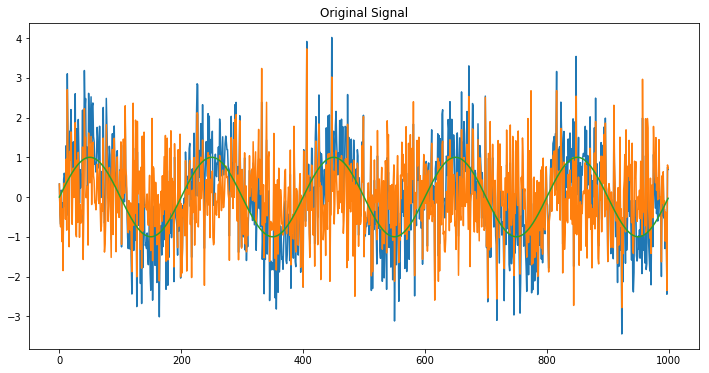

In [170]:
plt.figure(figsize=(12, 6))
plt.plot(signal_with_noise)
plt.plot(noise)
plt.plot(signal)
plt.title('Original Signal')

In [174]:
fft_of_signal_with_noise = np.fft.fft(signal)


f = np.fft.fftfreq(len(fft_of_signal_with_noise),sample_time)

def bandpass_filter(x, freq, frequency_of_signal=frequency_of_signal, band = 0.05):
    if (frequency_of_signal - band) < abs(freq) < (frequency_of_signal + band):
        return x
    else:
        return 0
    
F_filtered = np.asanyarray([bandpass_filter(x,freq) for x,freq in zip(fft_of_signal_with_noise, f)])
filtered_signal = np.fft.ifft(F_filtered)

[]

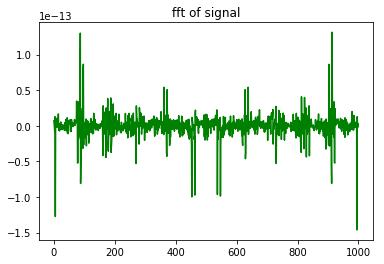

In [177]:
plt.plot(fft_of_signal_with_noise, color="green")
plt.title("fft of signal")
plt.plot()

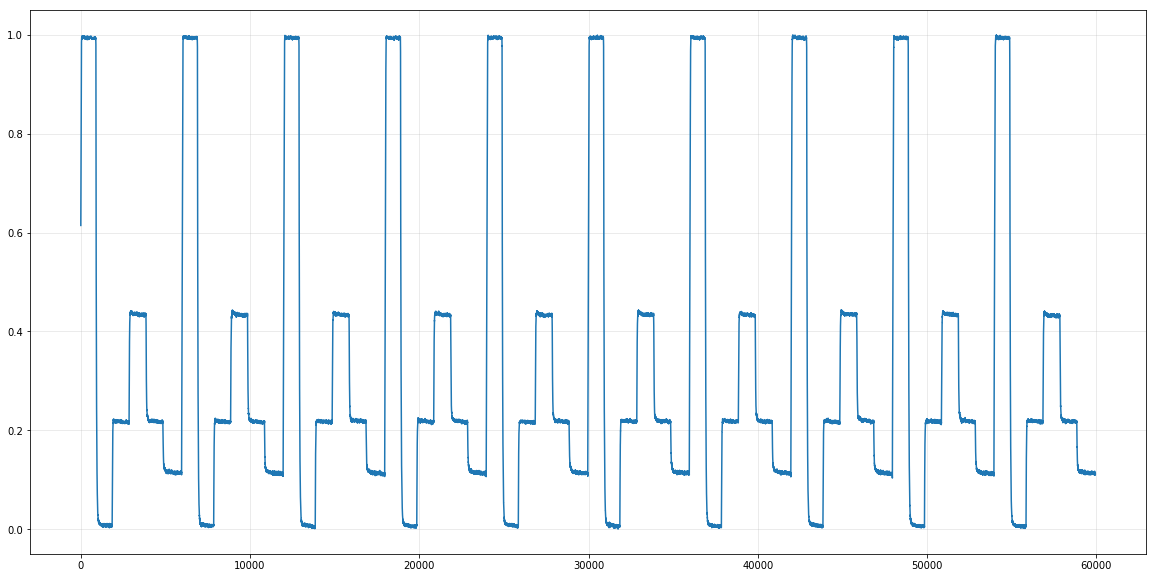

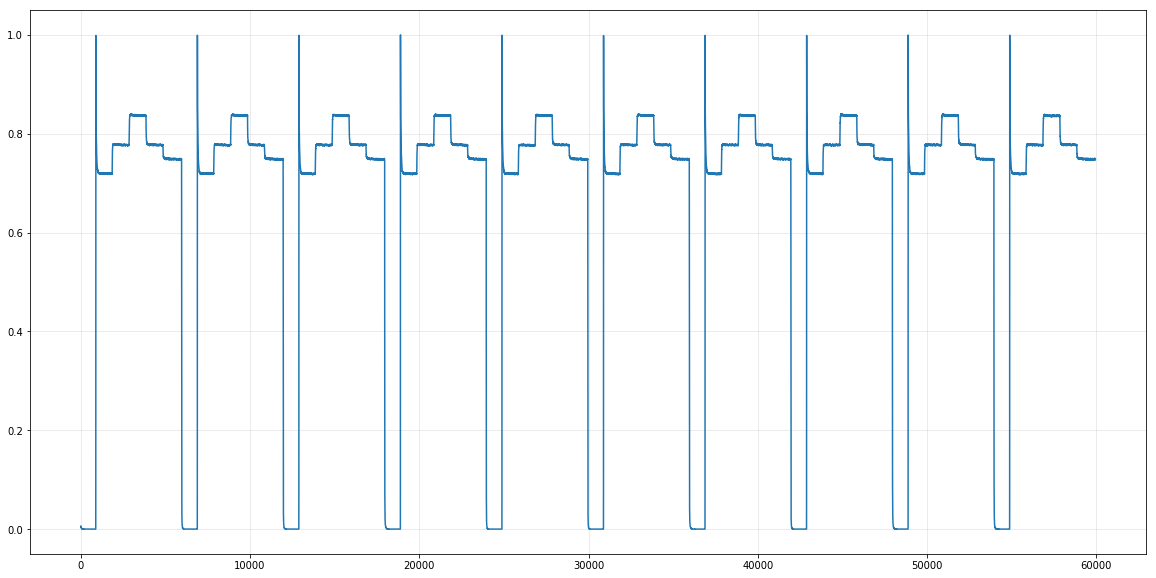

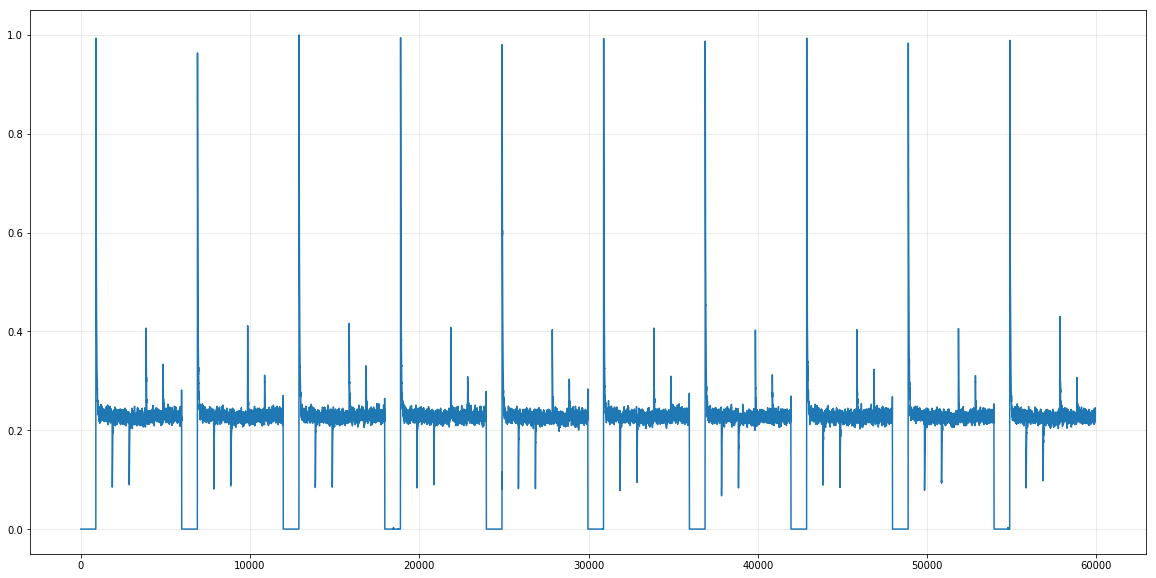

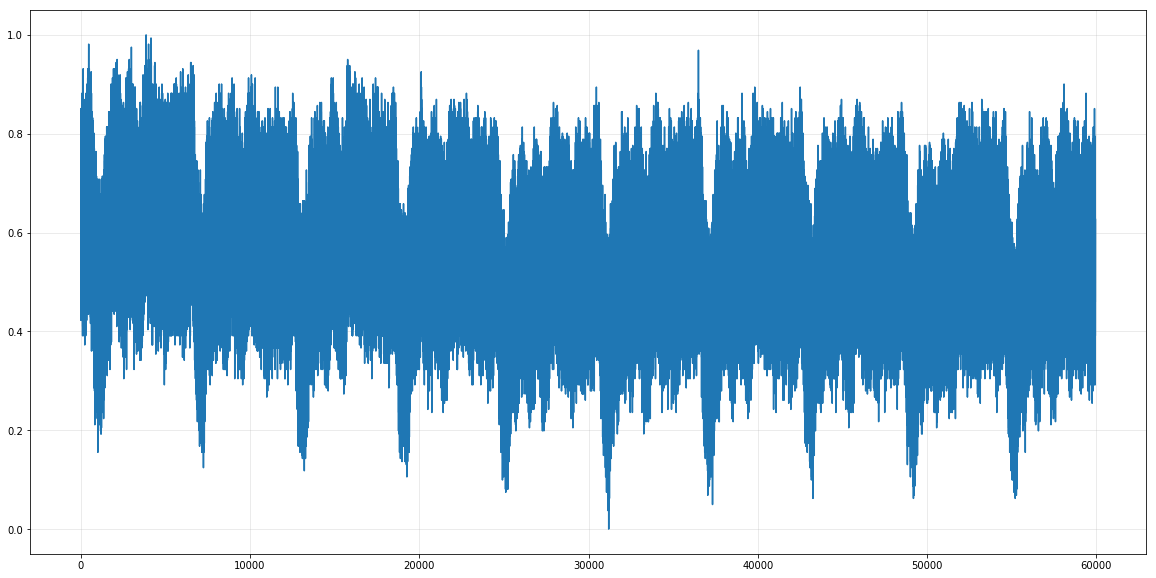

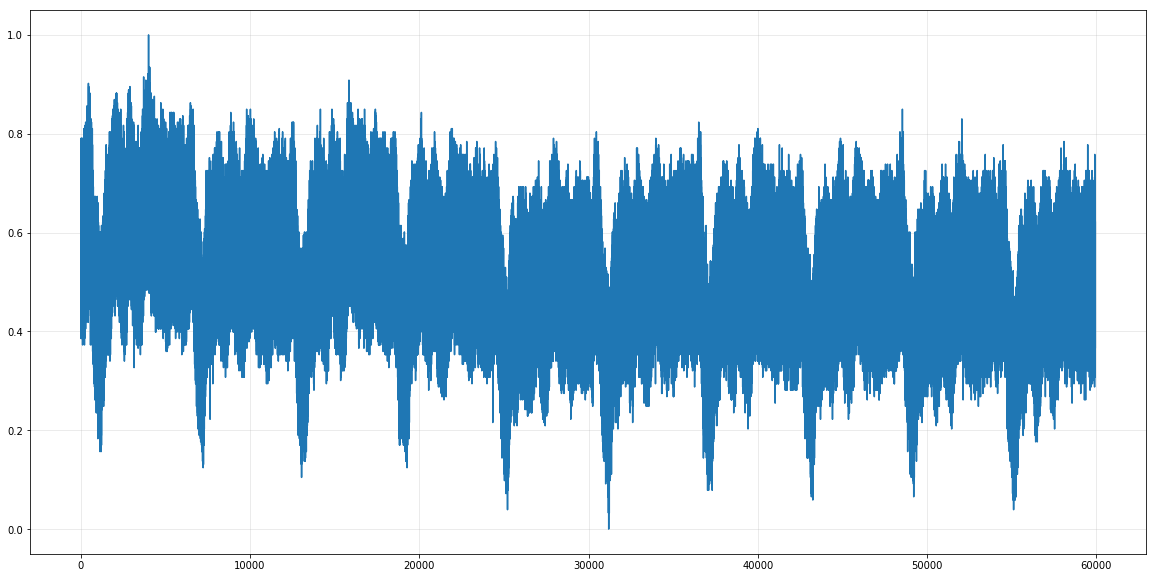

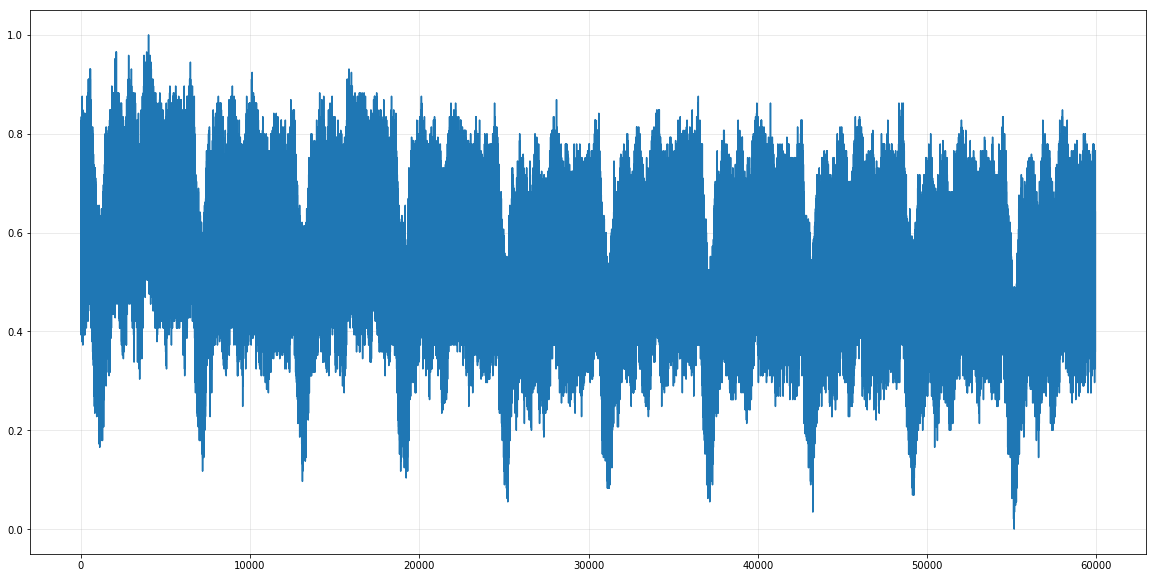

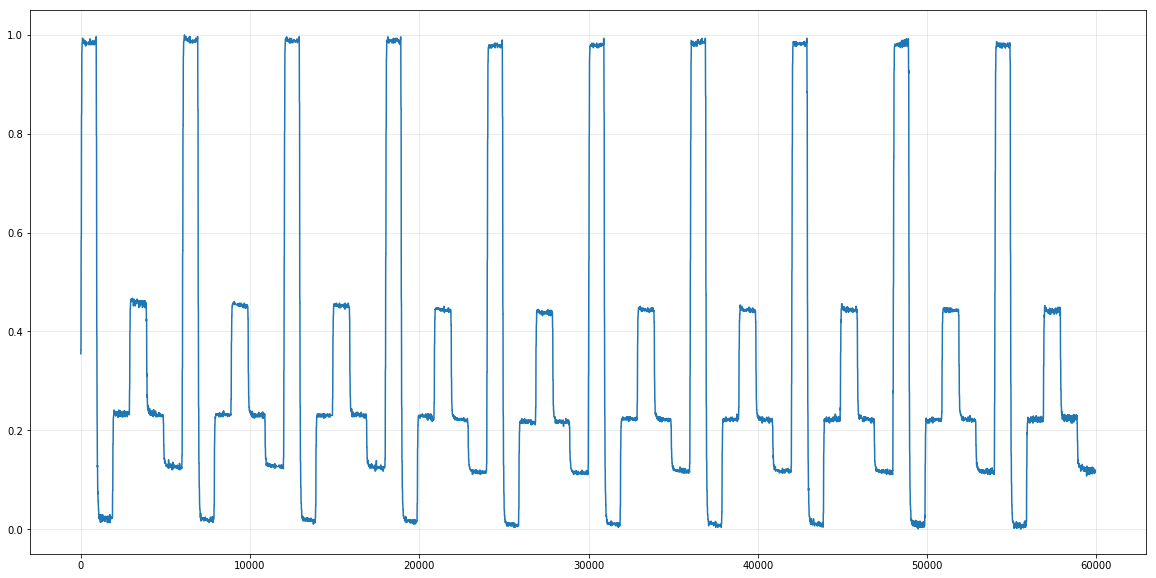

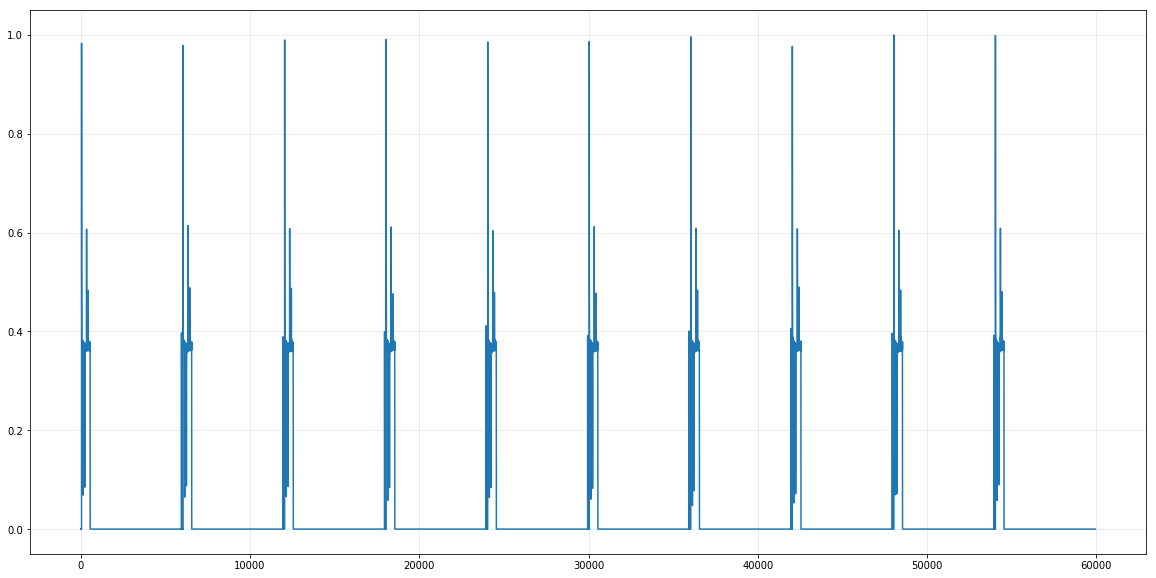

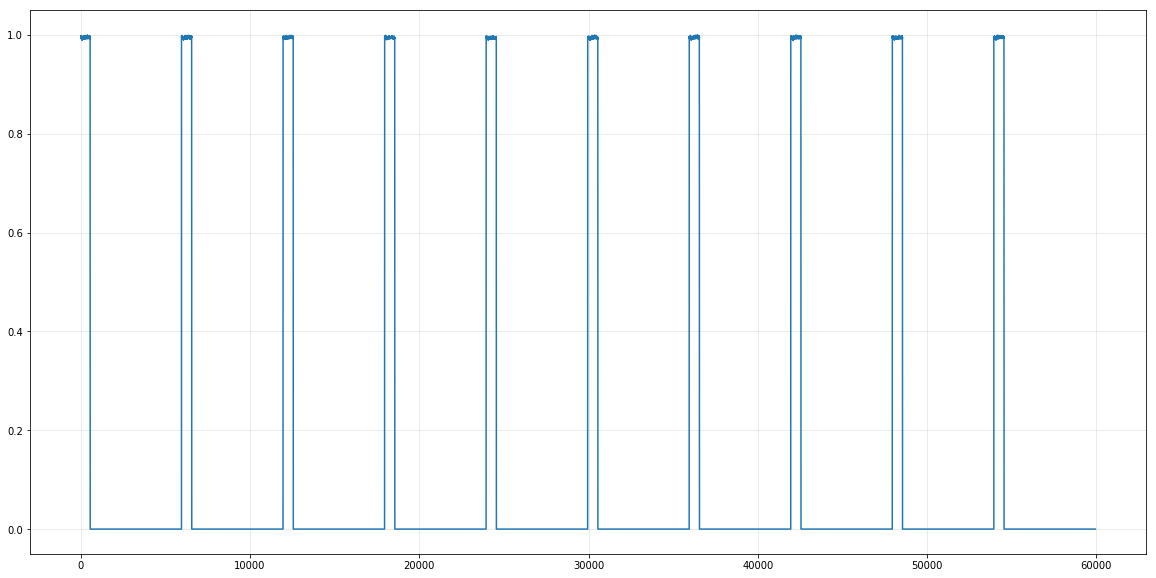

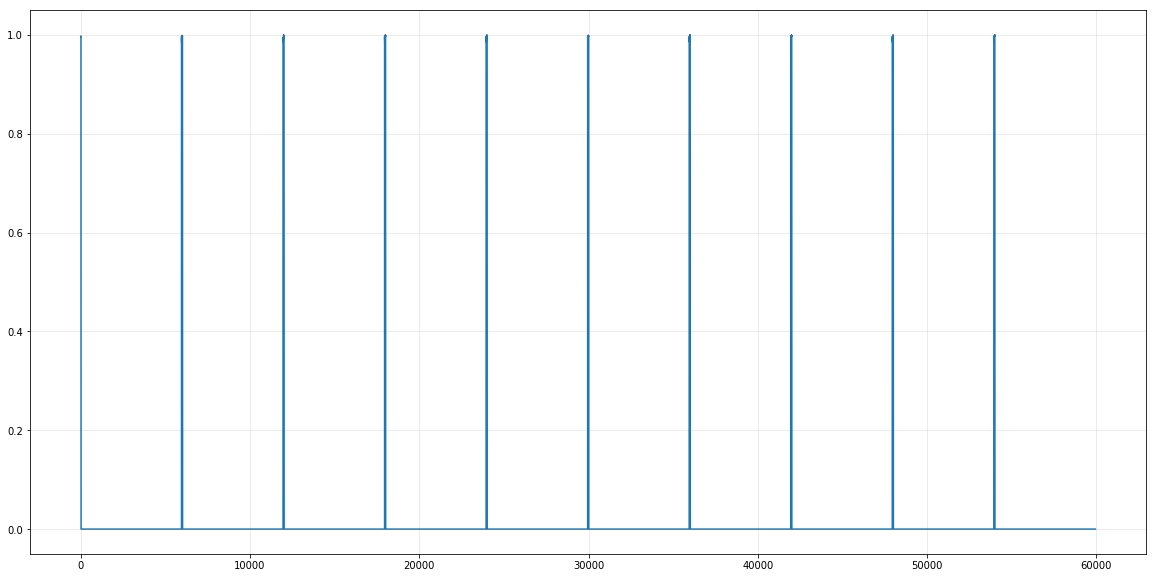

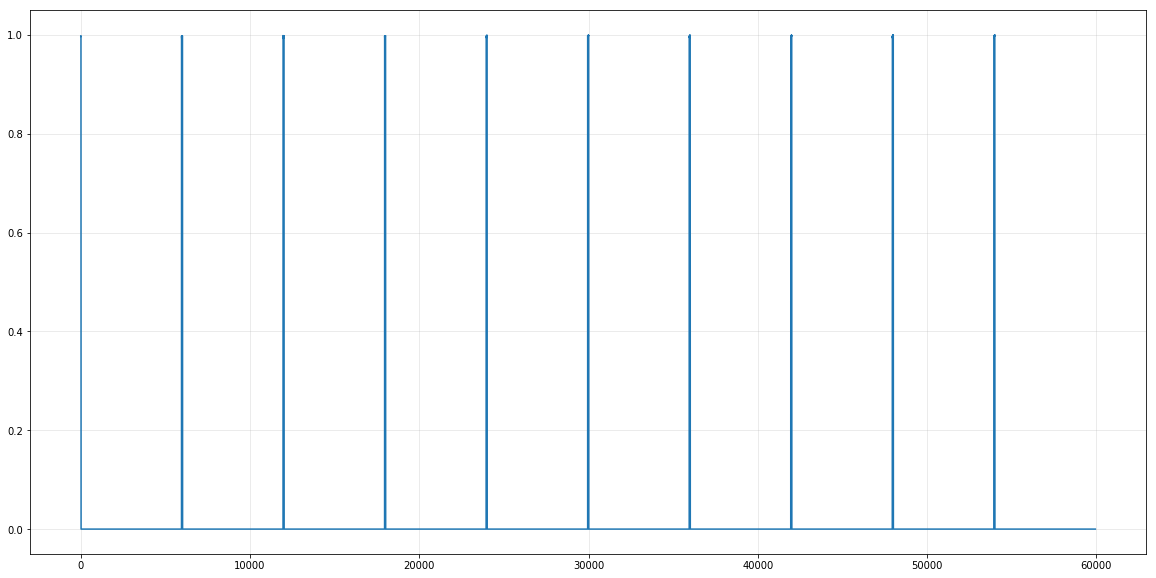

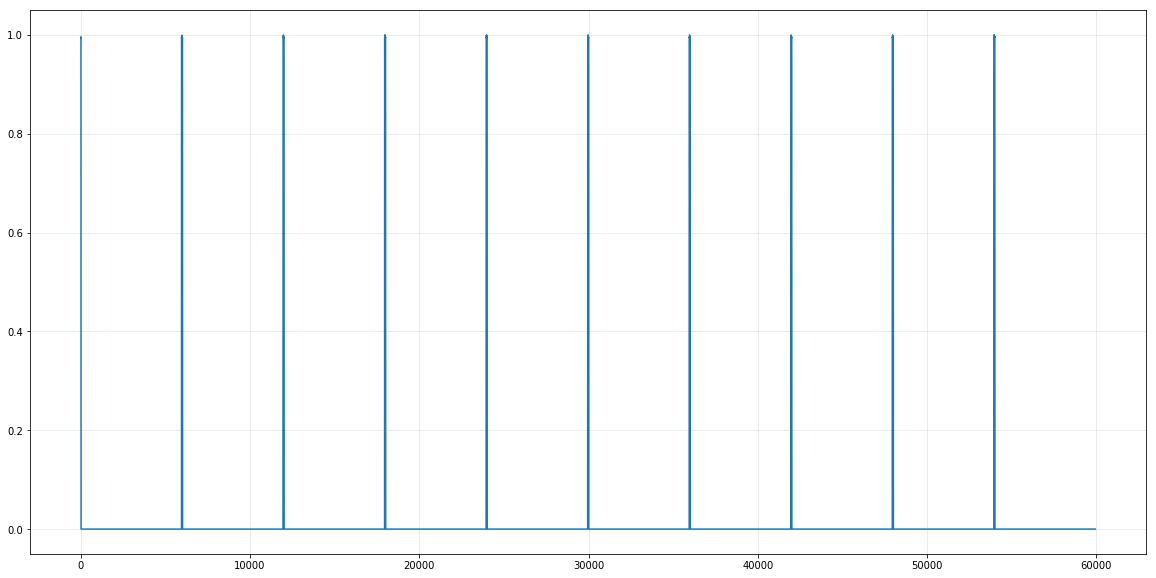

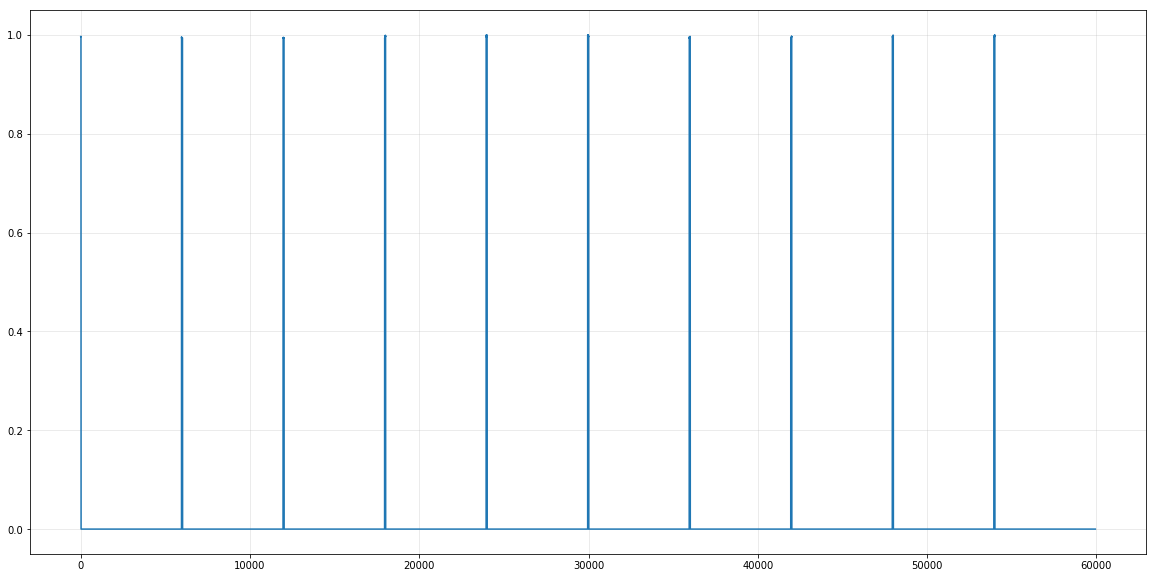

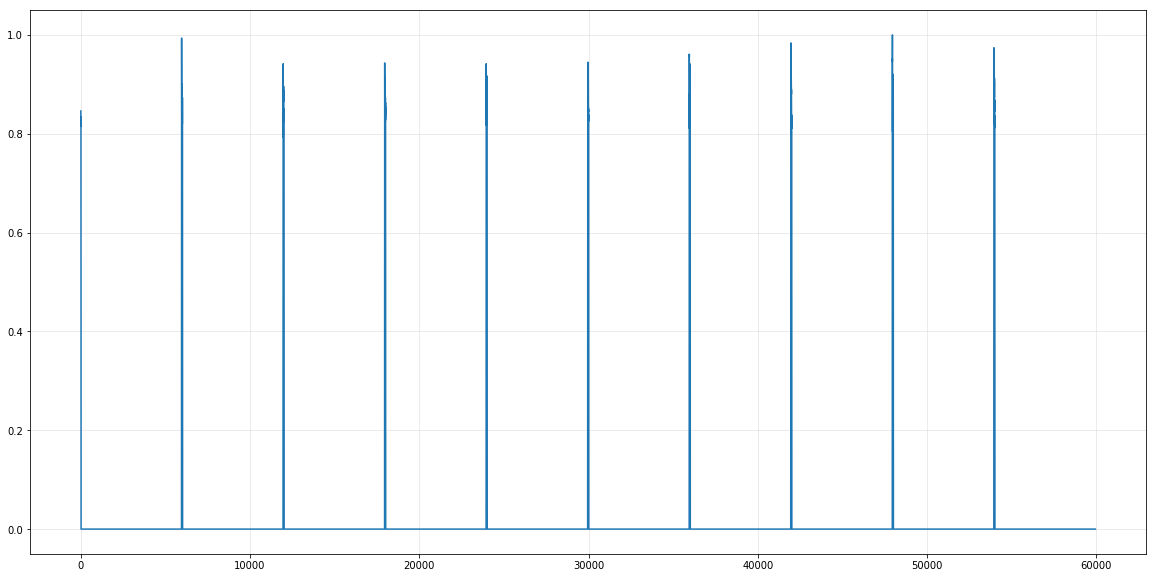

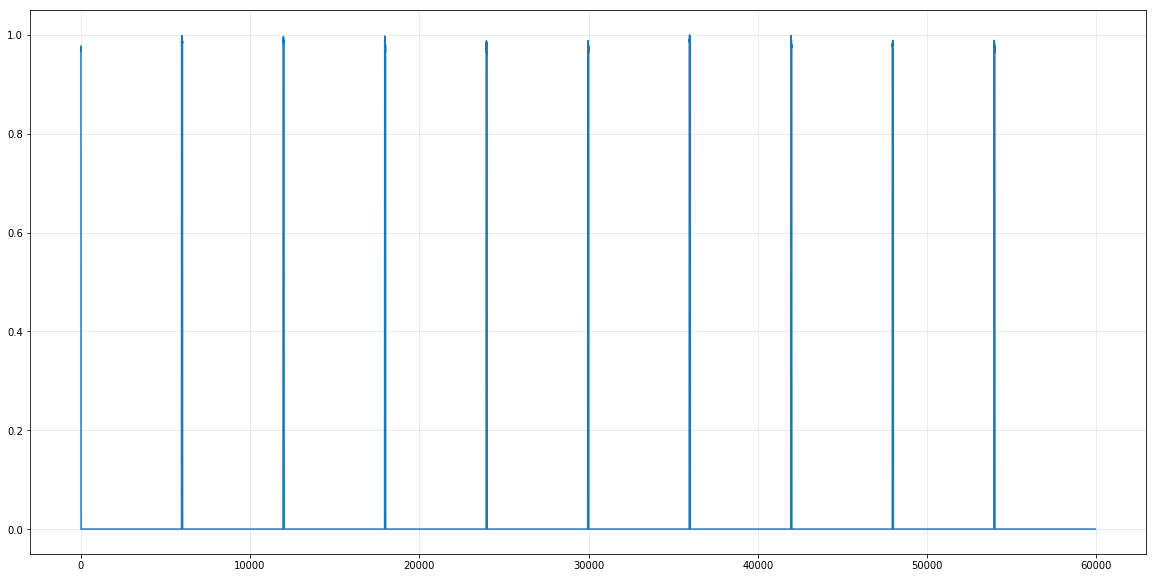

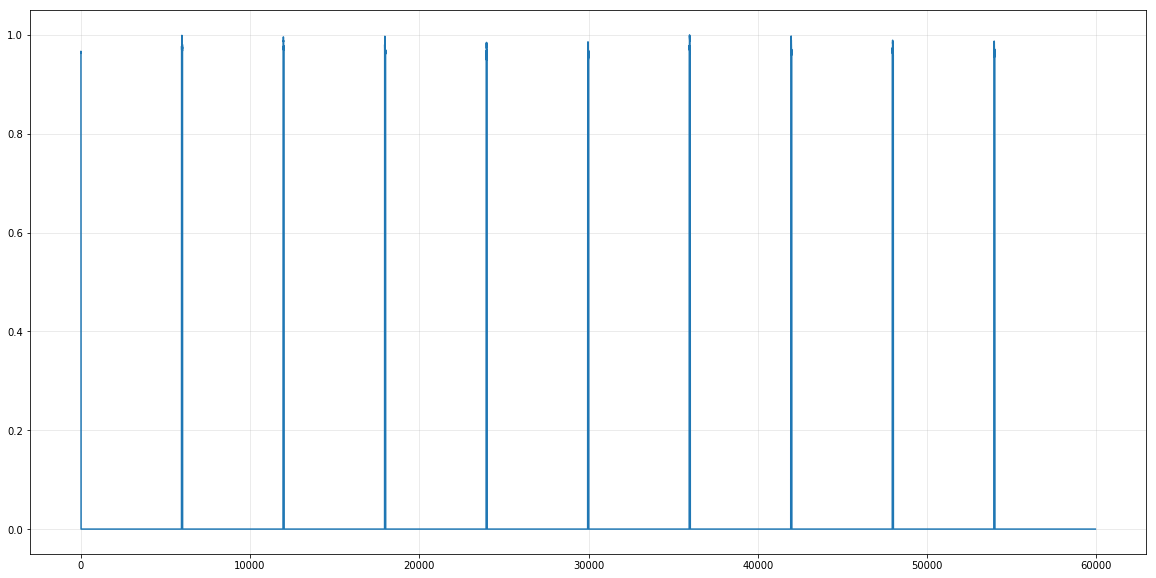

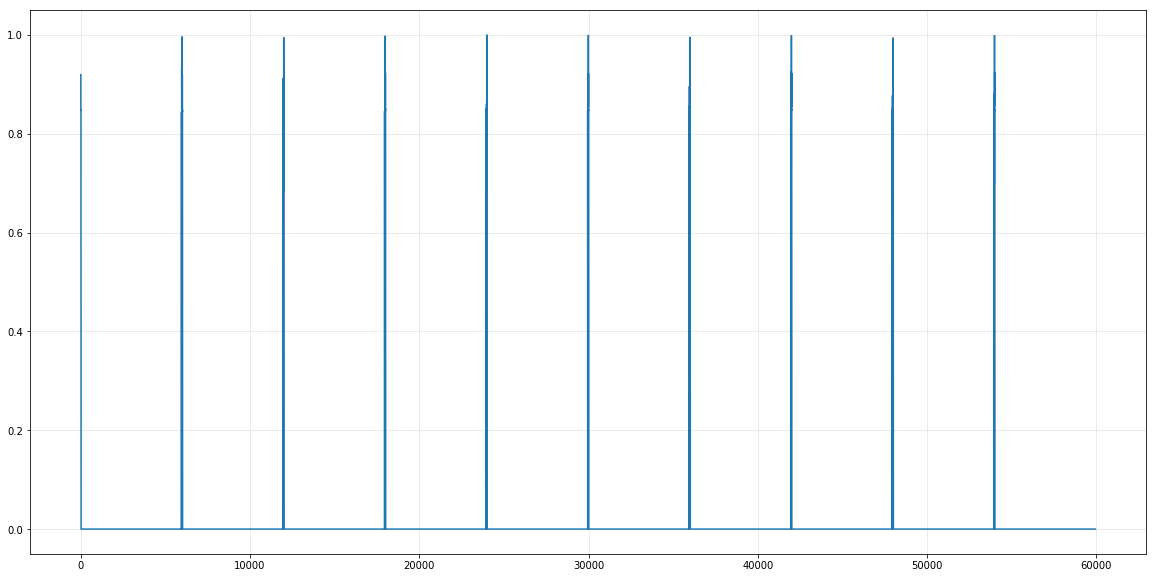

In [327]:
for i in range(0,17):
    plt.figure(figsize=(20,10))
    plt.plot(y_scaled_full_staked_tensor["c100_h130_pl2_v100_s0"][0:60000,i])
    plt.grid(True, alpha=0.3)
    plt.show()

In [54]:
fea=0
feature1anorm = np.fft.fft(y_scaled_full_staked_tensor["c100_h130_pl0_v100_s1"][0:60000,fea])
feature1norm = np.fft.fft(y_scaled_full_staked_tensor["c100_h130_pl0_v100_s0"][0:60000,fea])
res = np.fft.fft(test_anorm)
#feature1freq = np.fft.fftfreq(len(y_scaled_full_staked_tensor["c100_h130_pl0_v100_s1"][:,fea]), 6000)
#inver_feature1 = np.fft.ifft(feature1norm)

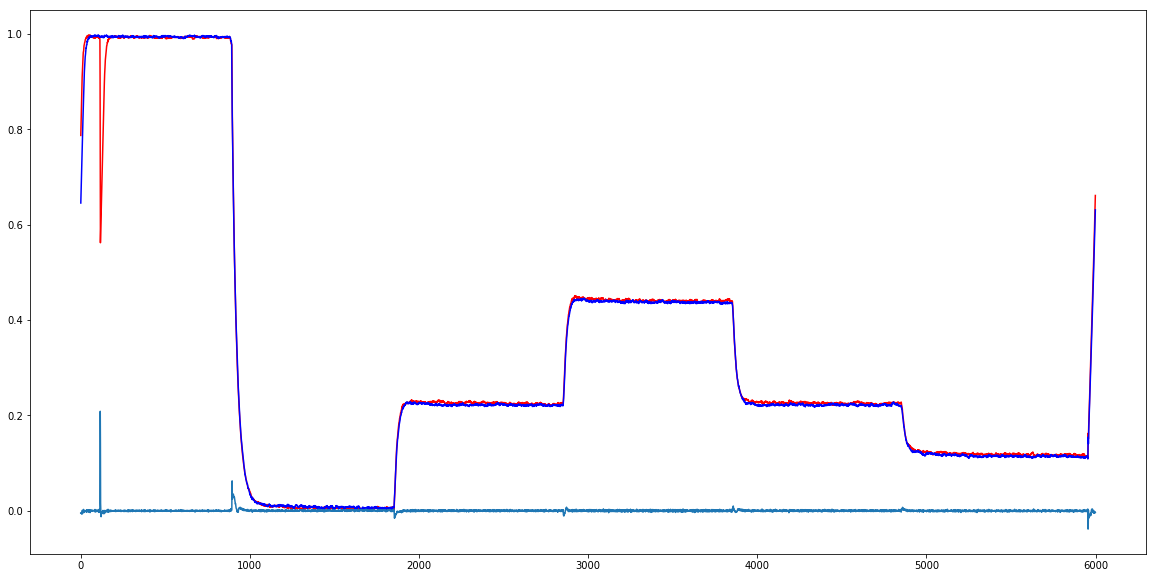

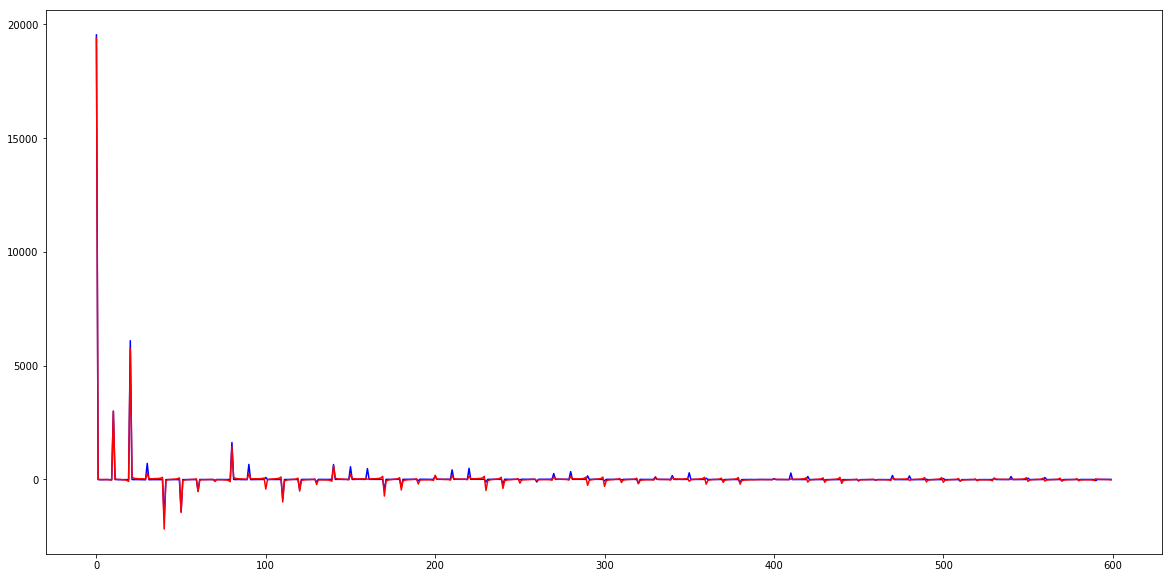

32487.53019139786

In [74]:
plt.figure(figsize=(20,10))
plt.plot(y_scaled_full_staked_tensor["c100_h130_pl0_v100_s1"][0:6000,0], color="red")
plt.plot(y_scaled_full_staked_tensor["c100_h130_pl0_v100_s0"][0:6000,0], color="blue")
plt.plot(res[0:6000])
plt.show()

difference = feature1anorm[0:600]- feature1norm[0:600]
plt.figure(figsize=(20,10))
plt.plot(feature1anorm[0:600], color="blue")
plt.plot(feature1norm[0:600], color="red")
#plt.plot(sum(abs(difference)), color="red")
#plt.plot(res[0:60000], color="green")
plt.show()

#difference 
sum(abs(difference))

In [349]:
residuen_scaled_predictions_vanilla_dict_1["c100_h130_pl0_v100_s0"].shape

(250, 250)

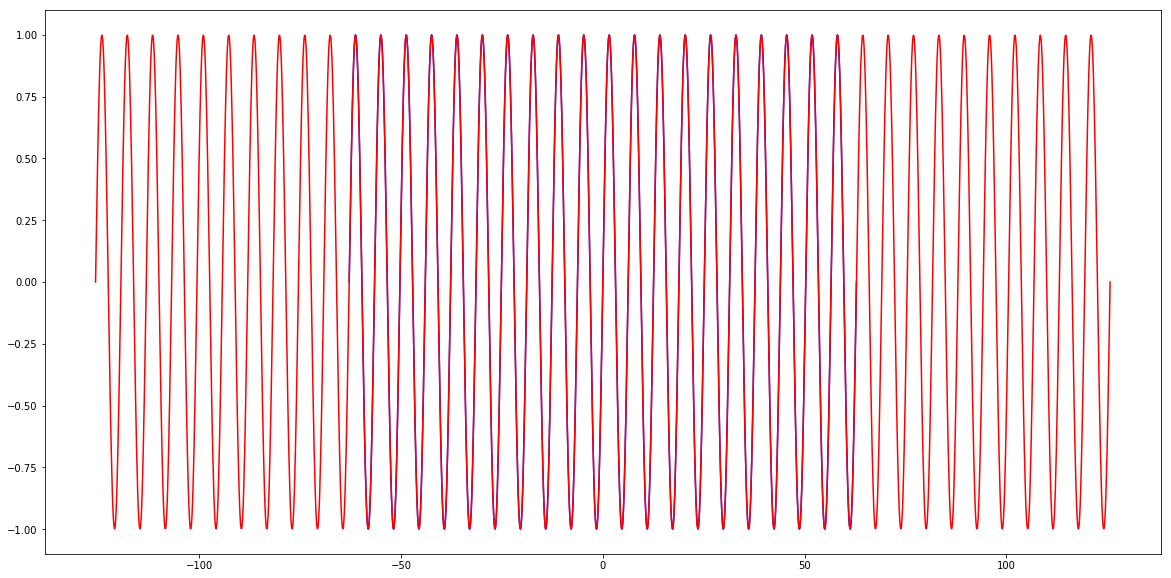

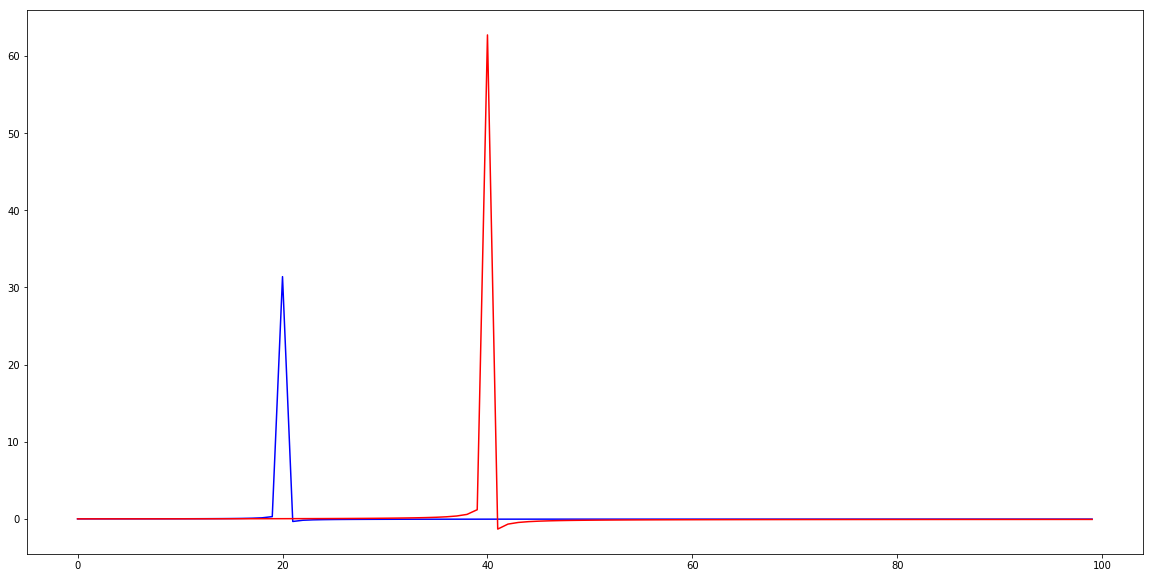

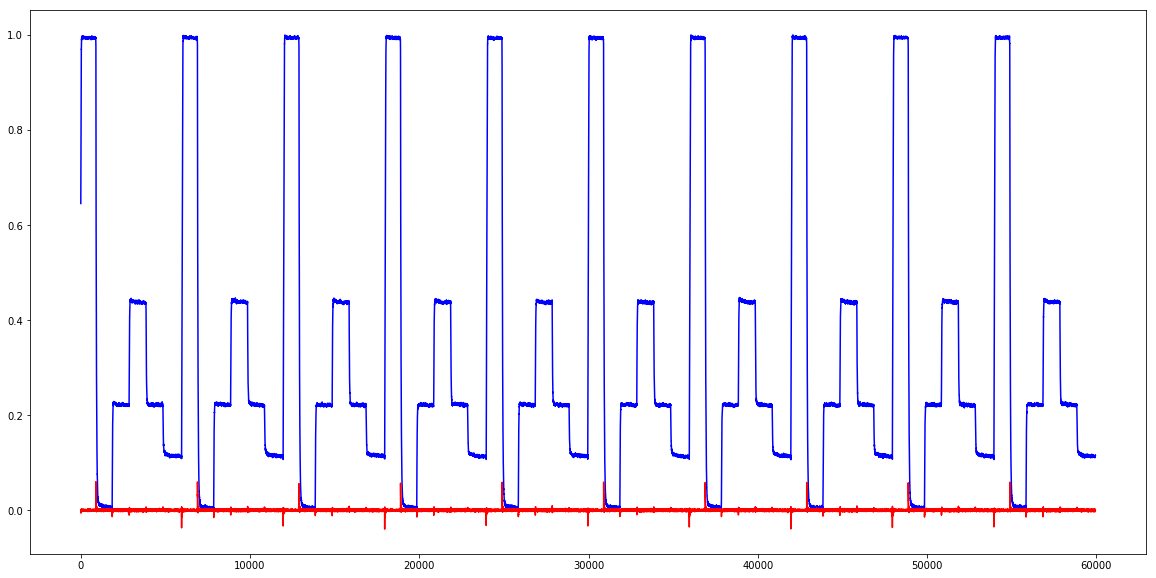

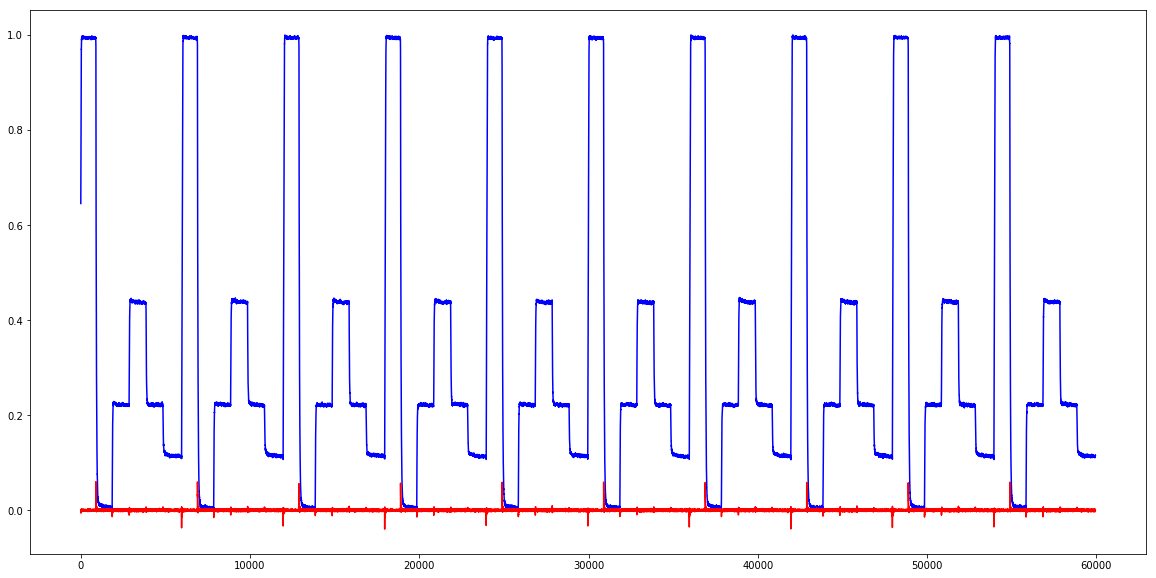

In [62]:
fs = 100 # sample rate 
f = 40 # the frequency of the signal

#x = np.arange(fs) # the points on the x axis for plotting
# compute the value (amplitude) of the sin wave at the for each sample
x20 = np.linspace(-20*np.pi, 20*np.pi, 2001)
x40 = np.linspace(-40*np.pi, 40*np.pi, 2001)
xfeature = np.linspace(1,60000,60000)
y20 = np.sin(x20)
y40 = np.sin(x40)
yfeature1= y_scaled_full_staked_tensor["c100_h130_pl0_v100_s0"][:,0:1]
yresiduen1 = test_norm
#y1anorm = feature1anorm[0:60000]
#y1norm= feature1anorm[0:60000]
#y20[20] = 50
#print(y)
plt.figure(figsize=(20,10))
plt.plot(x20,y20, color="blue")
plt.plot(x40, y40, color="red")
plt.show()

from scipy import fftpack
#test = fftpack.fftfreq(len(y), )
#y_scaled_full_staked_tensor["c100_h130_pl0_v100_s0"][0:60000,fea]

x20_signal = fftpack.fft(y20)
x40_signal = fftpack.fft(y40)

yfeature1_signal = fftpack.fft(yfeature1)
yresiduen1_signal = fftpack.fft(yresiduen1)

plt.figure(figsize=(20,10))
plt.plot(x20_signal[0:100], color="blue")
plt.plot(x40_signal[0:100], color="red")
plt.show()

######residuen + norm
plt.figure(figsize=(20,10))
plt.plot(yfeature1, color="blue")
plt.plot(yresiduen1, color="red")
plt.show()

######fft 
plt.figure(figsize=(20,10))
plt.plot(yfeature1_signal, color="blue")
plt.plot(yresiduen1_signal, color="red")
plt.show()